# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic simulation dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Synthetic environment works.

#### RL setup for Synthetic
In Synthetic , the objective of the RL agent is to maximize reward

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.


For more about the environmental configuration and its customization, please refer to [examples/quickstart/basic_synthetic_customize_env.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/basic_synthetic_customize_env.ipynb).

In [9]:
# standardized environment for continuous action
env = gym.make("BasicEnv-continuous-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Synthetic environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/basic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/basic_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  
        maximum=env_.action_space.high,  
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [ ]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=10000,
    n_steps_per_epoch=100,
    update_start_step=100,
)

In [ ]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [12]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

In [13]:
behavior_policy_05 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)
behavior_policy_10 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)
behavior_policy_20 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([2.0]),
    name="sac_sigma_2.0",
    random_state=random_state,
)
behavior_policies = [behavior_policy_05, behavior_policy_10, behavior_policy_20]

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [44]:
with open("logs/train_dataset_continuous_sac_5.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac_5.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [15]:
with open("logs/train_dataset_continuous_sac_5.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac_5.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

<!-- For more about the offline RL procedure, please refer to [examples/quickstart/synthetic_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_basic.ipynb). -->

In [16]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import CQL, IQL

In [17]:
# evaluation policies
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [18]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [ ]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

In [45]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [19]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [20]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [21]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [22]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [23]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [24]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [46]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [25]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [26]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [27]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [30]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[behavior_policies[0].name][0]

{'cql_b1_gauss_05':            policy_value  relative_policy_value
 on_policy  2.883189e+00           1.000000e+00
 dm         2.166604e+00           7.514610e-01
 tis        1.170861e+26           4.060995e+25
 pdis       3.584442e+23           1.243221e+23
 dr        -1.289905e+26          -4.473884e+25
 sntis      2.331597e+00           8.086868e-01
 snpdis    -2.844714e-01          -9.866555e-02
 sndr       1.143572e+00           3.966345e-01,
 'cql_b1_gauss_10':            policy_value  relative_policy_value
 on_policy  1.225472e+00           1.000000e+00
 dm         2.119889e+00           1.729855e+00
 tis        1.938110e+26           1.581521e+26
 pdis       9.174796e+23           7.486744e+23
 dr        -2.059208e+26          -1.680338e+26
 sntis      2.283637e+00           1.863475e+00
 snpdis    -4.300003e-01          -3.508854e-01
 sndr       3.767257e-01           3.074127e-01,
 'cql_b2_gauss_05':            policy_value  relative_policy_value
 on_policy  3.168800e+00     

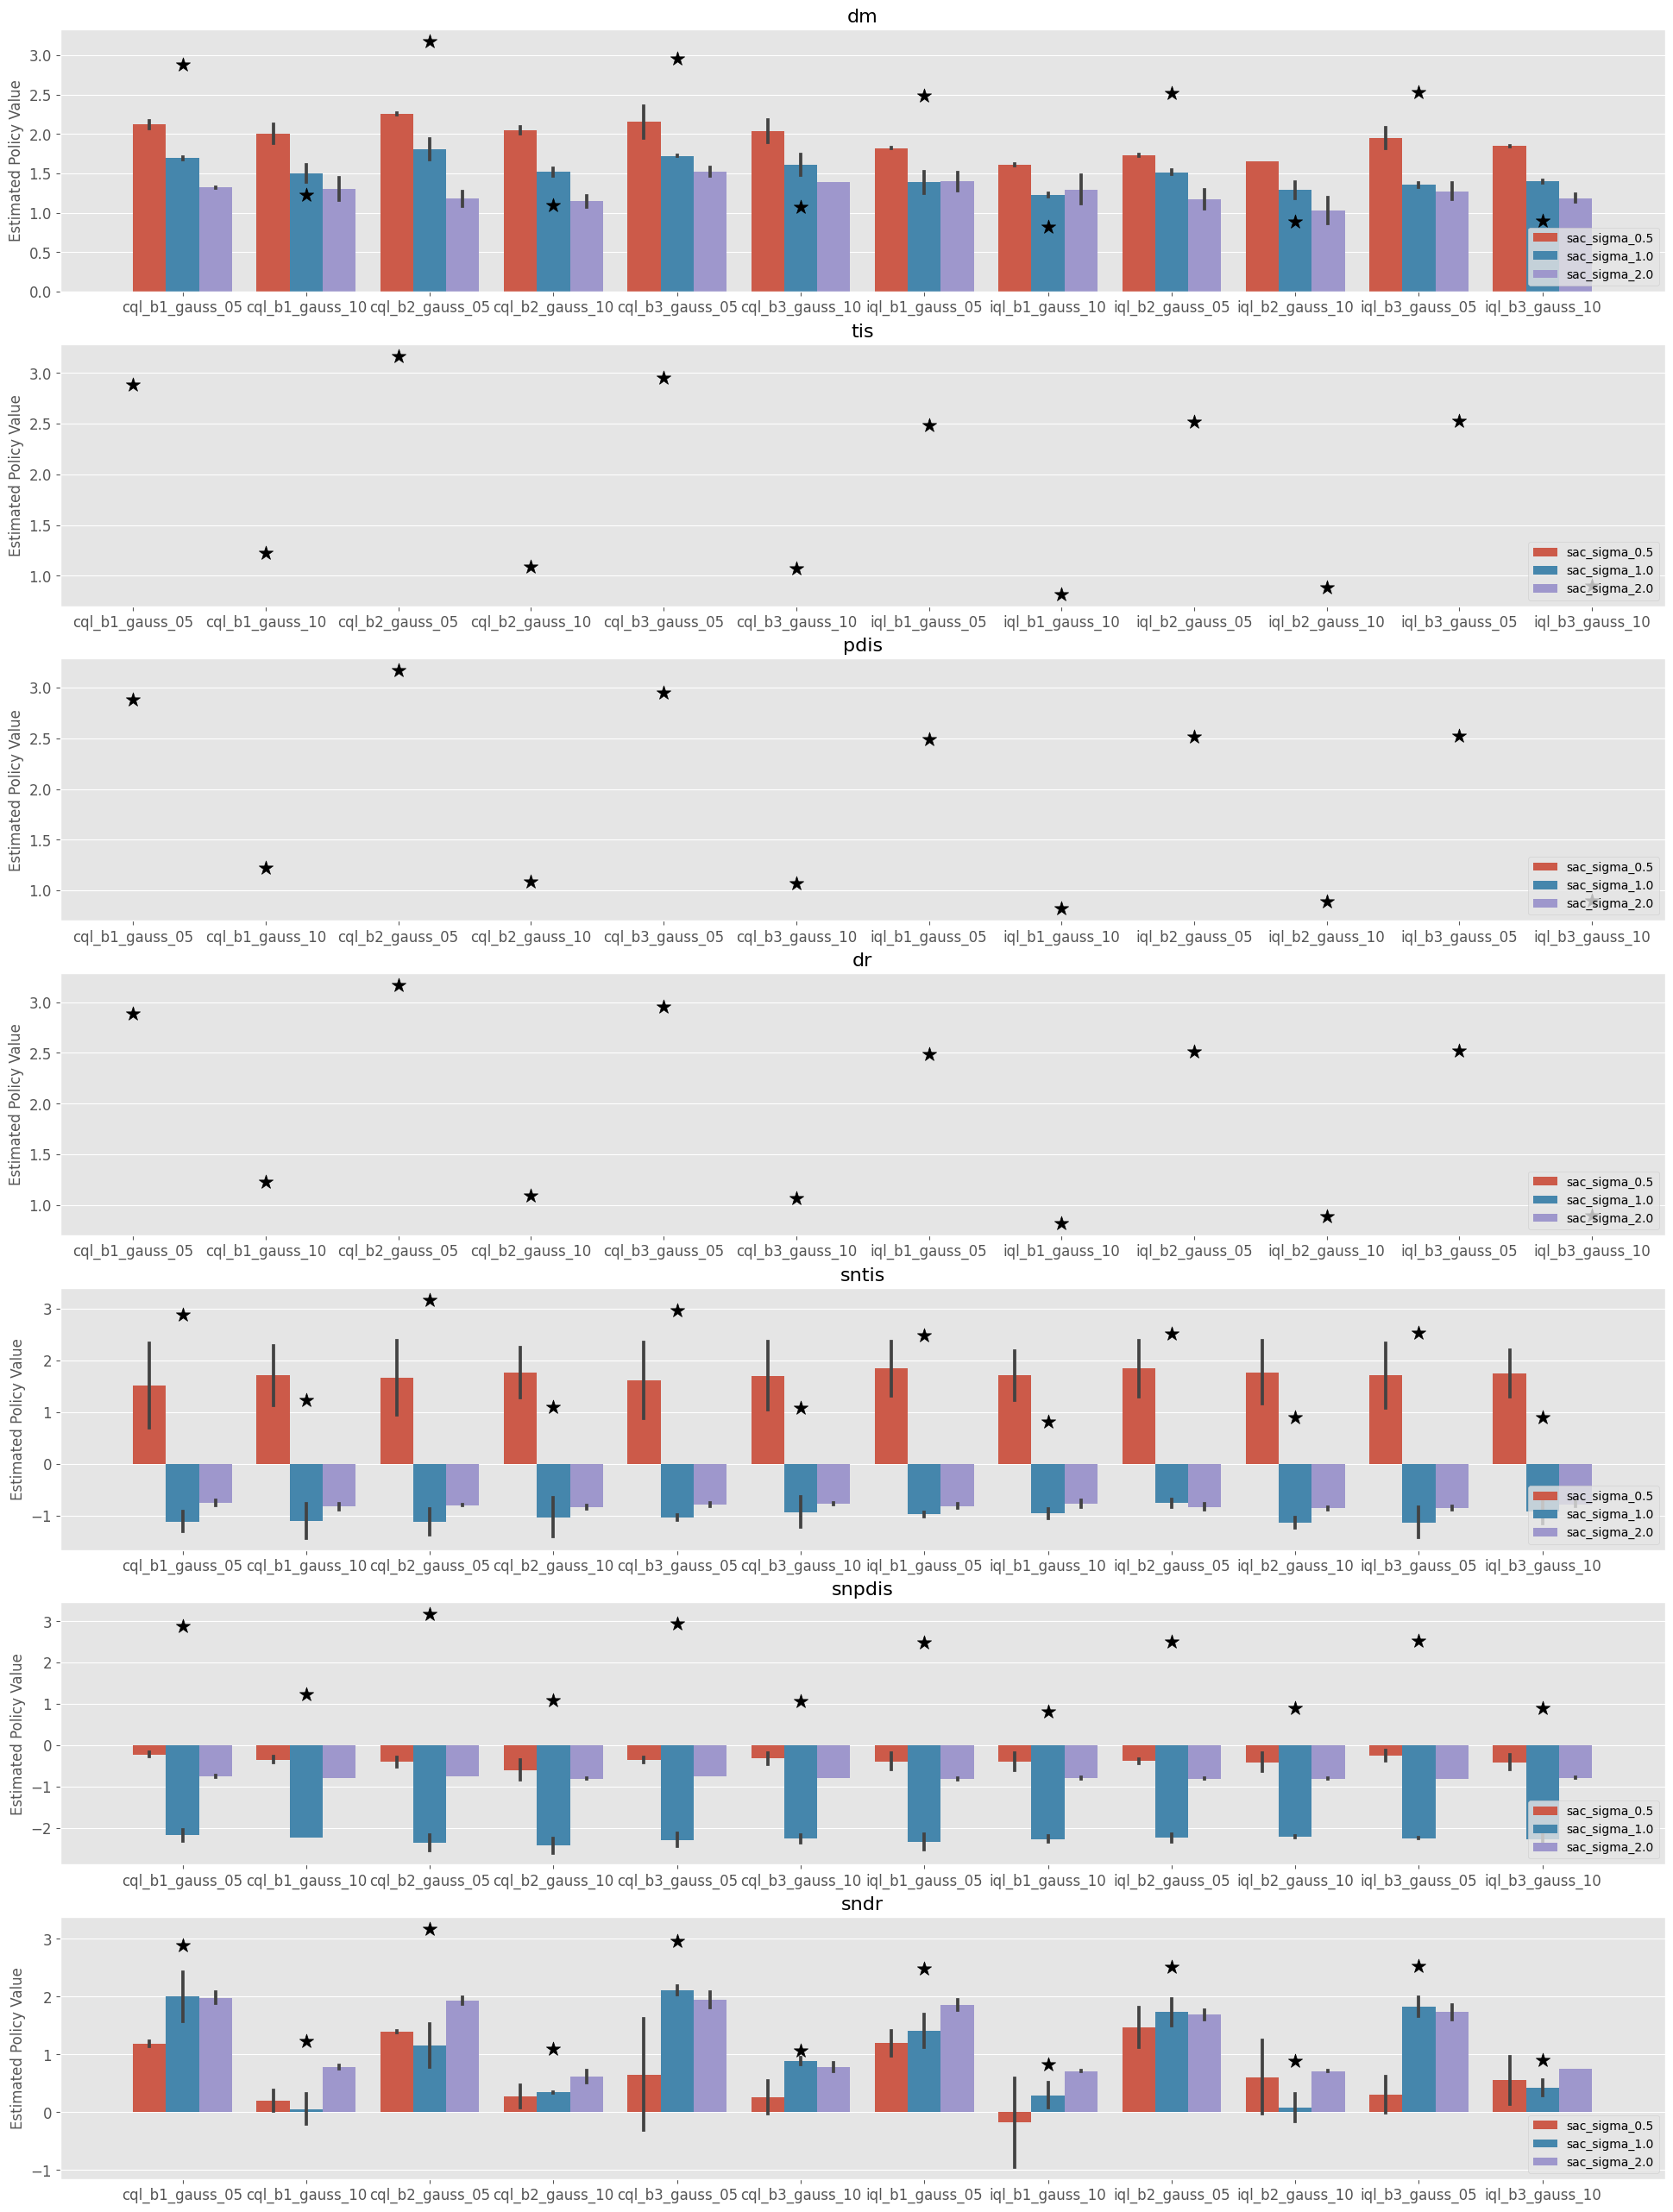

In [31]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

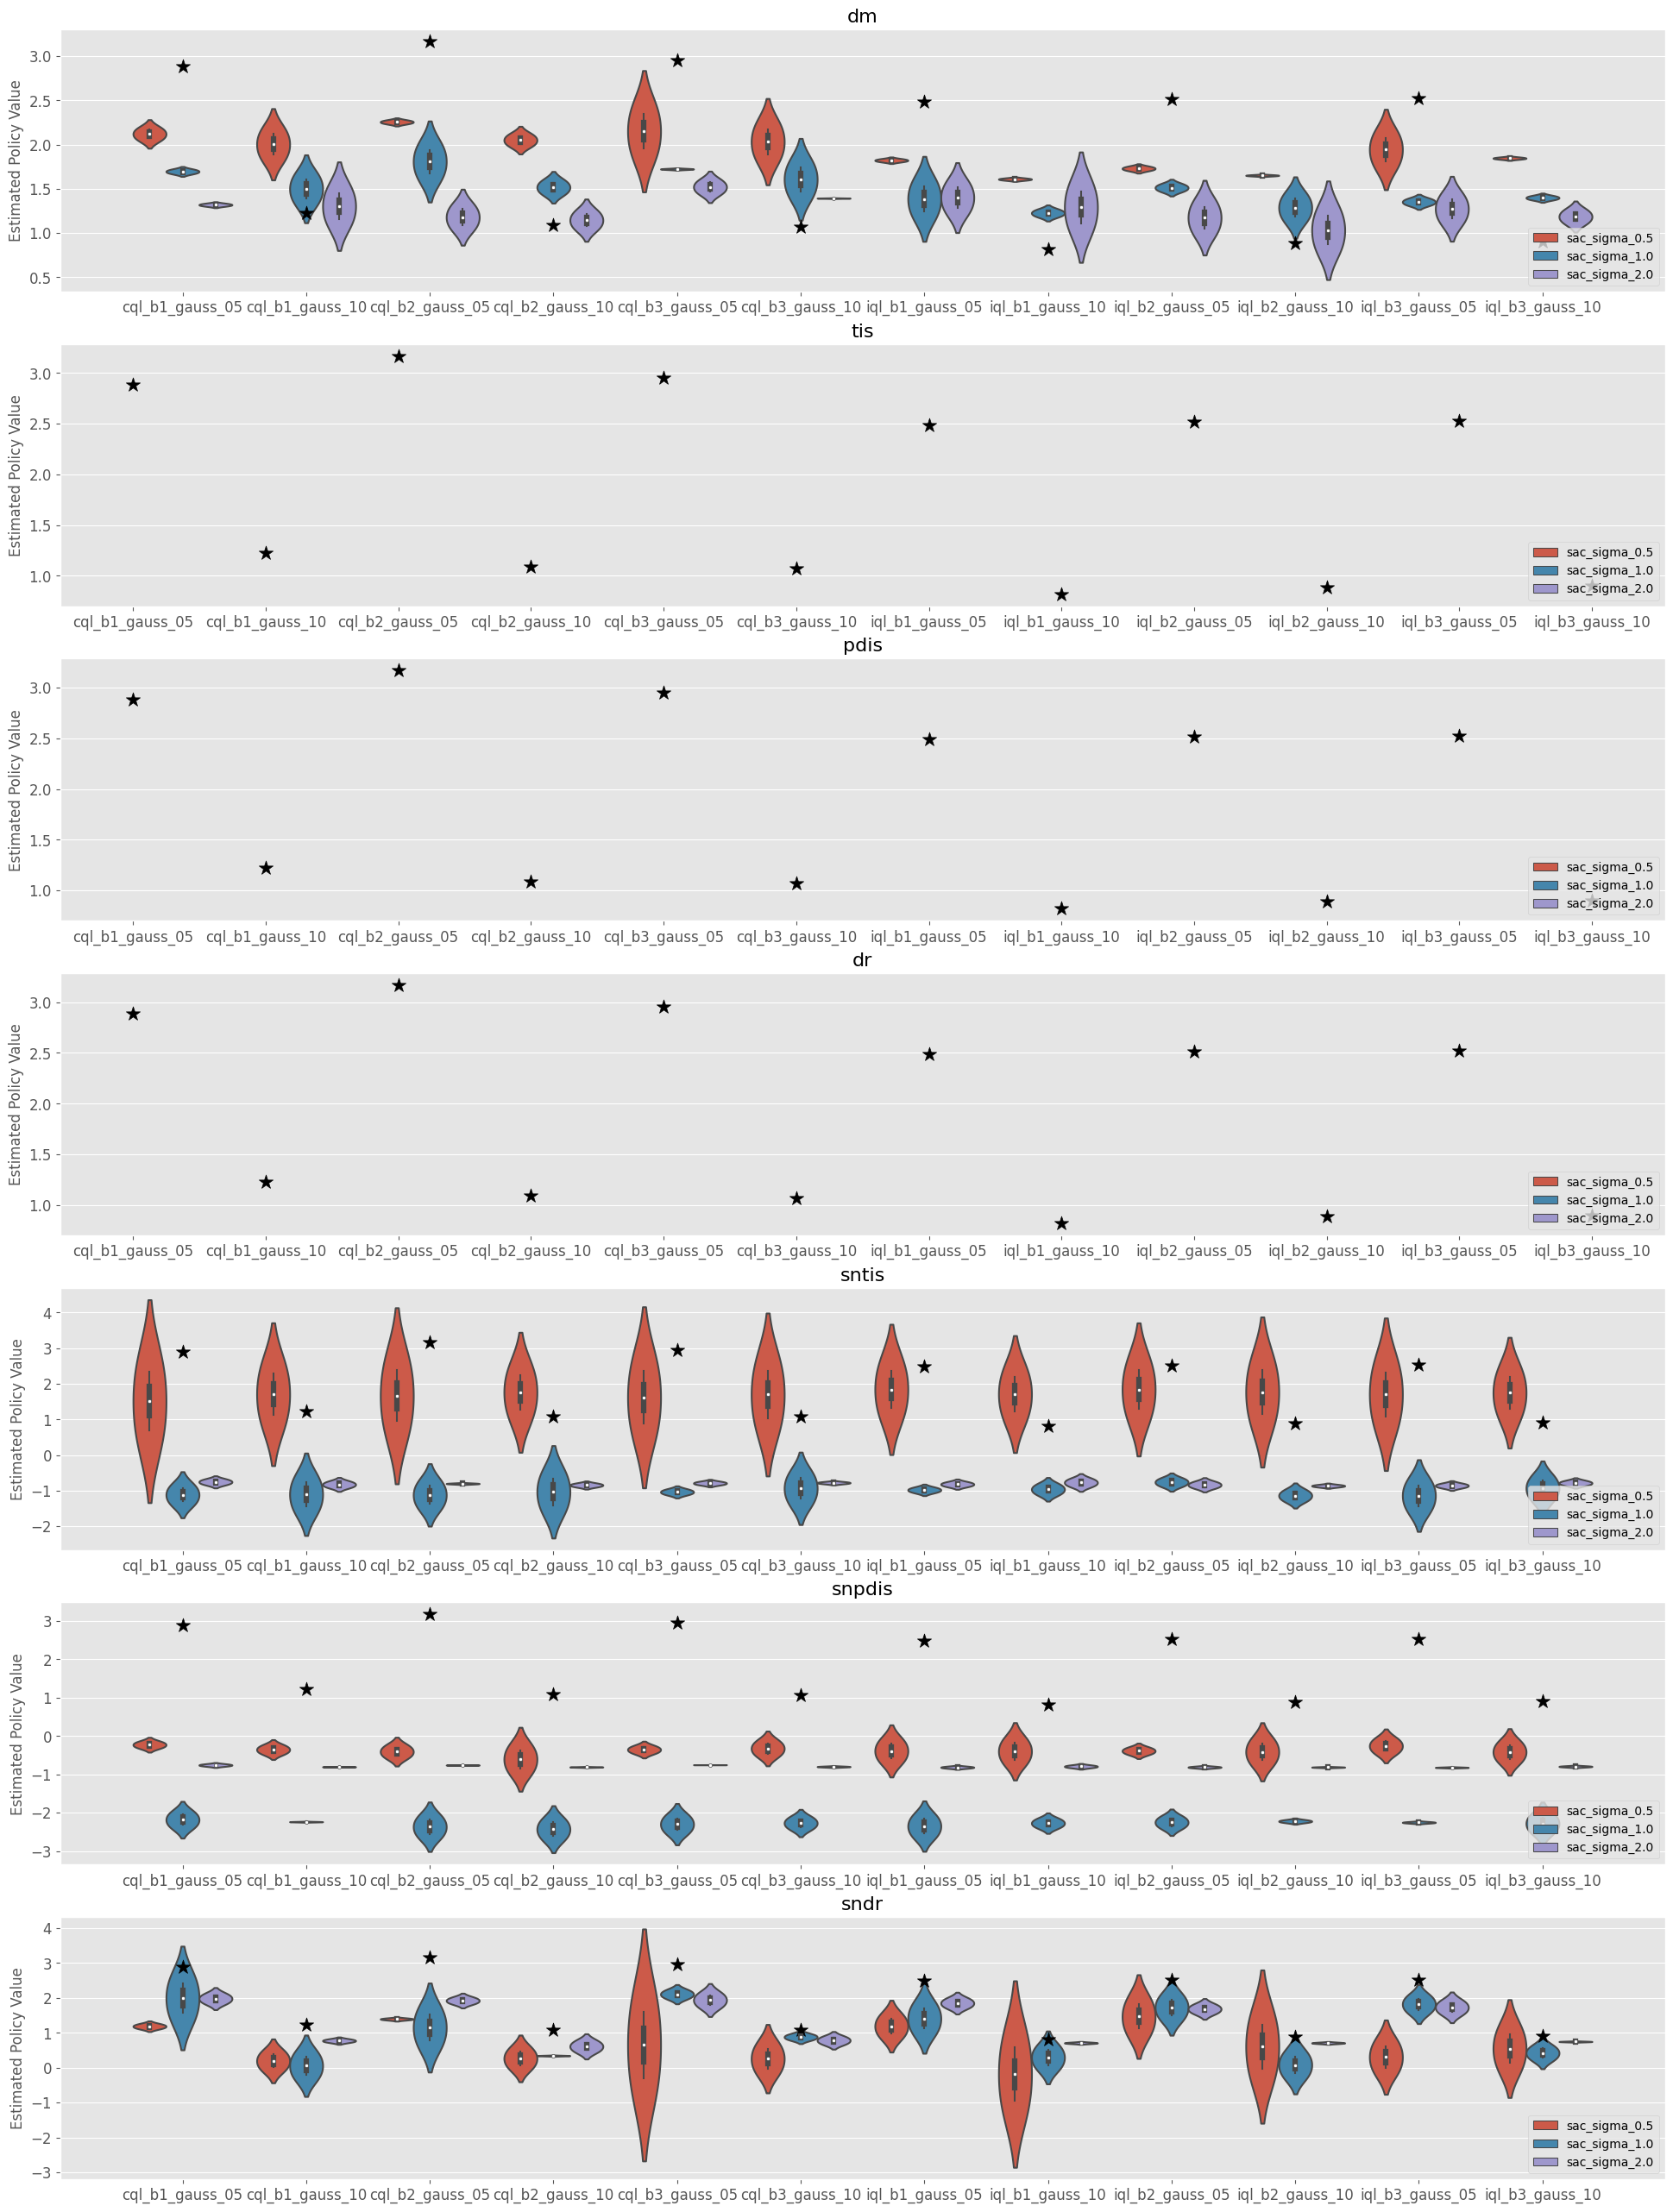

In [32]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

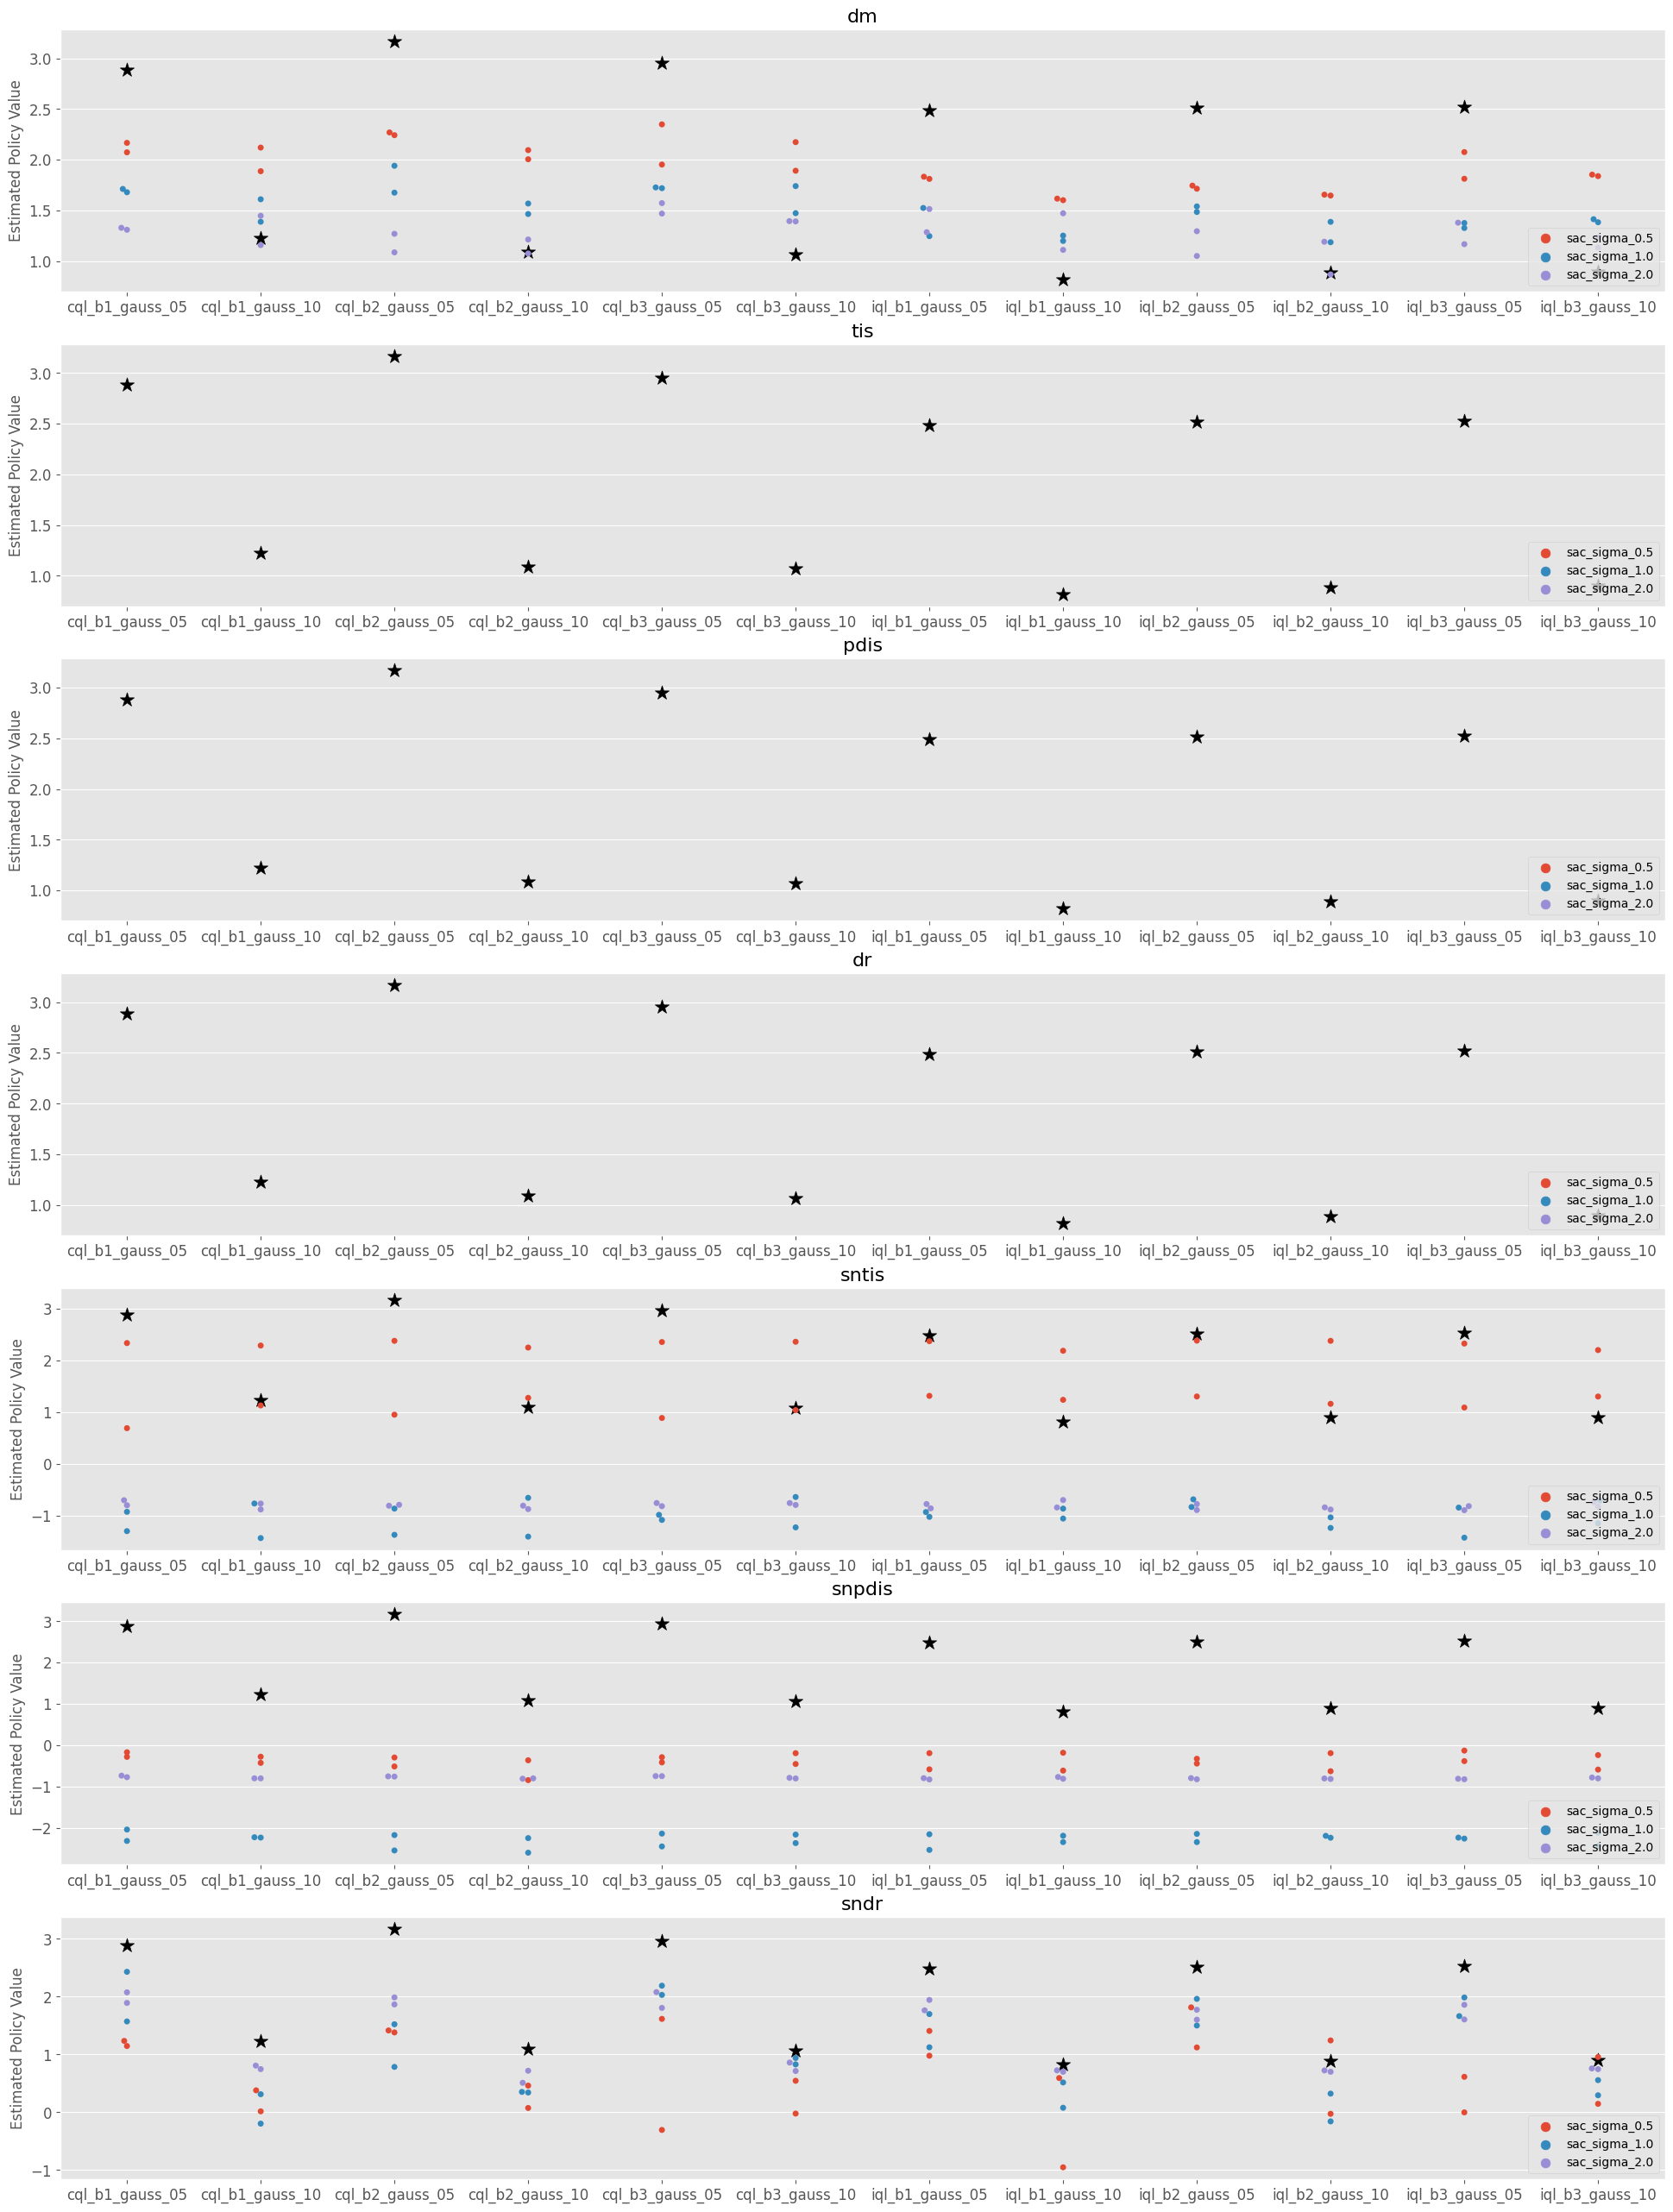

In [33]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [28]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [29]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

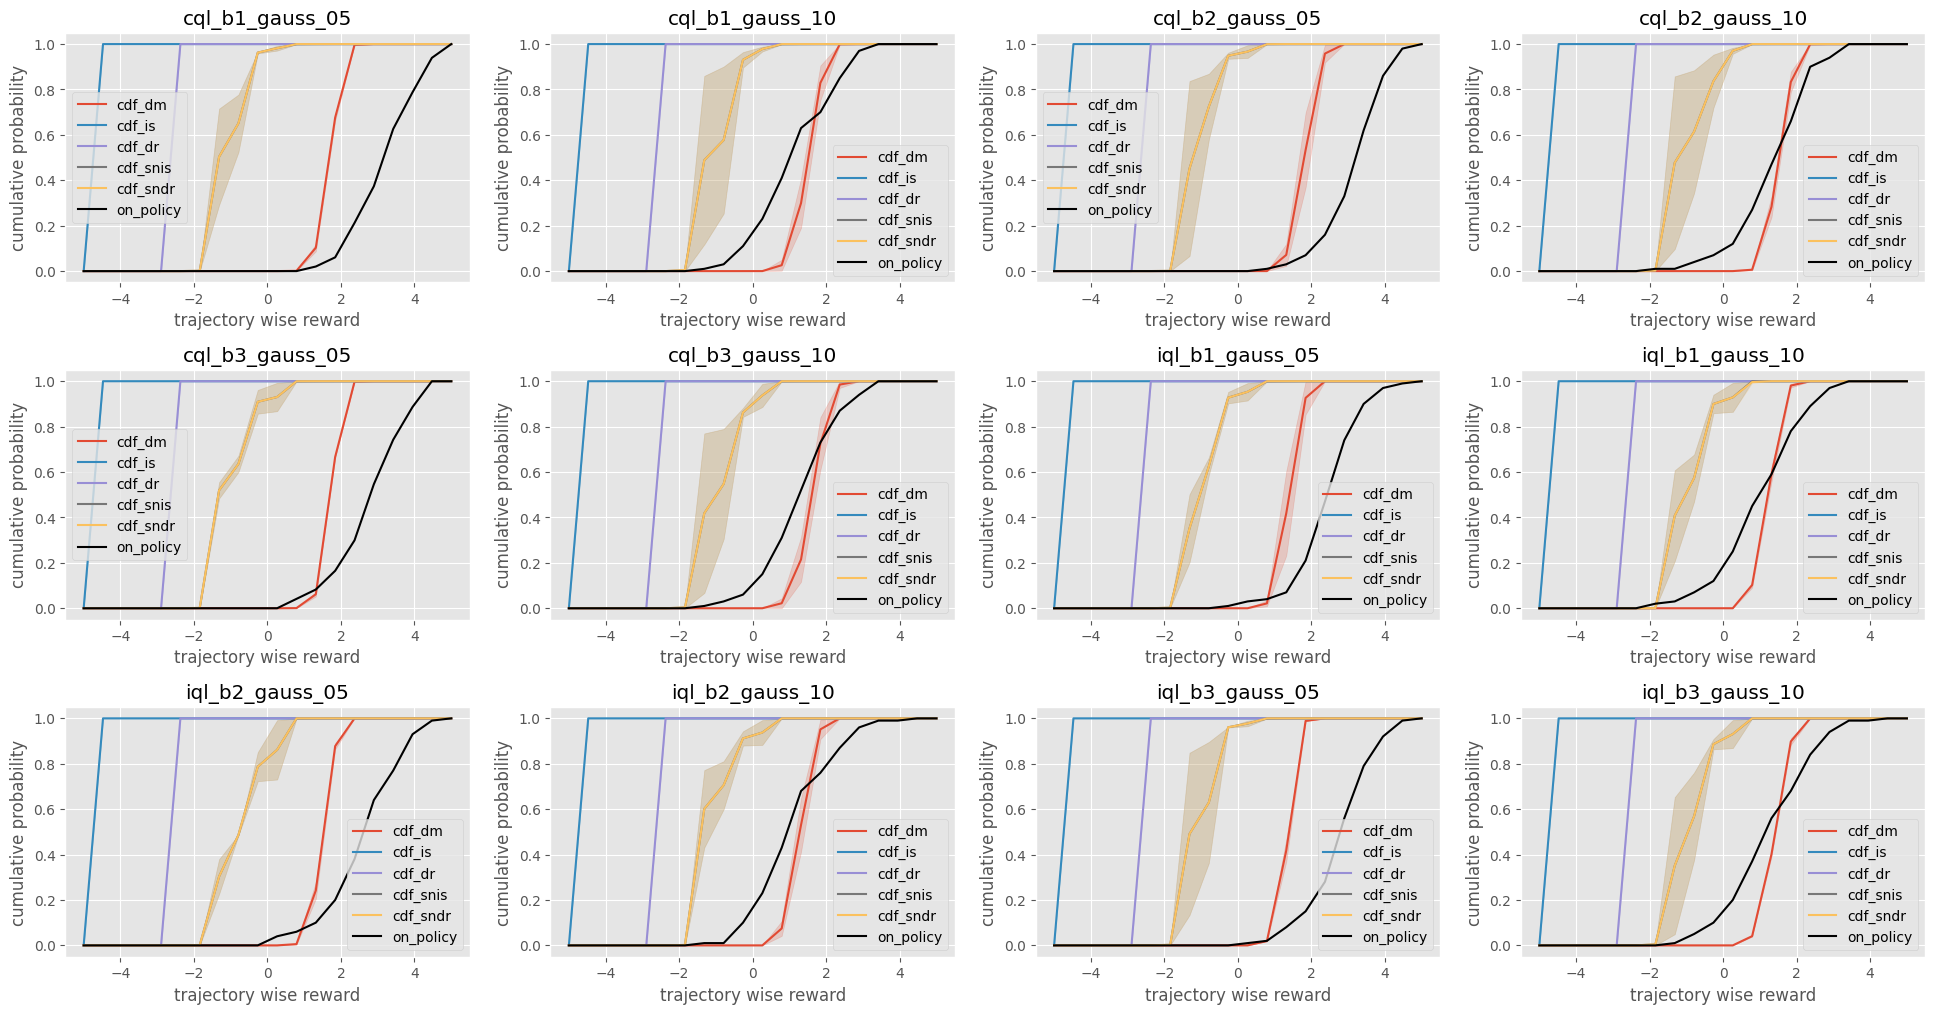

In [36]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="ci_hue",
    scale_min=-5.0, 
    scale_max=5.0, 
    n_partition=20, 
    n_cols=4,
)

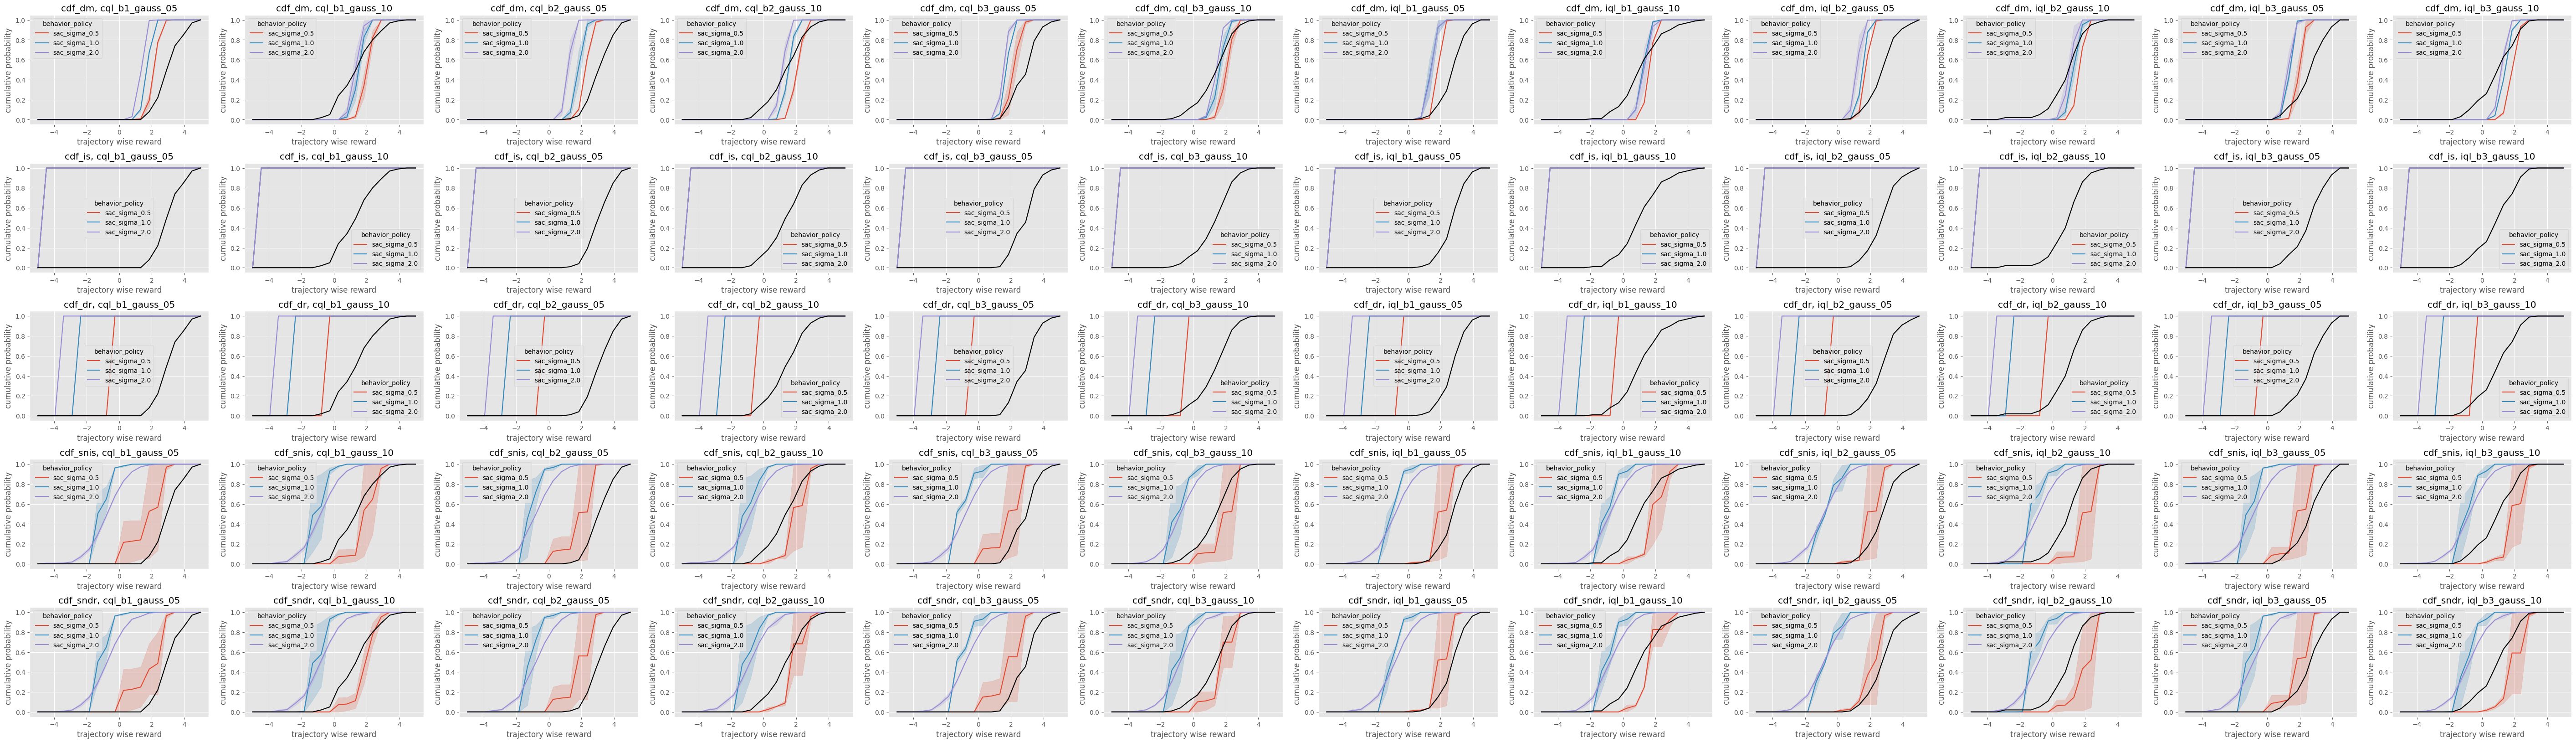

In [37]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=-5.0, 
    scale_max=5.0, 
    n_partition=20, 
)

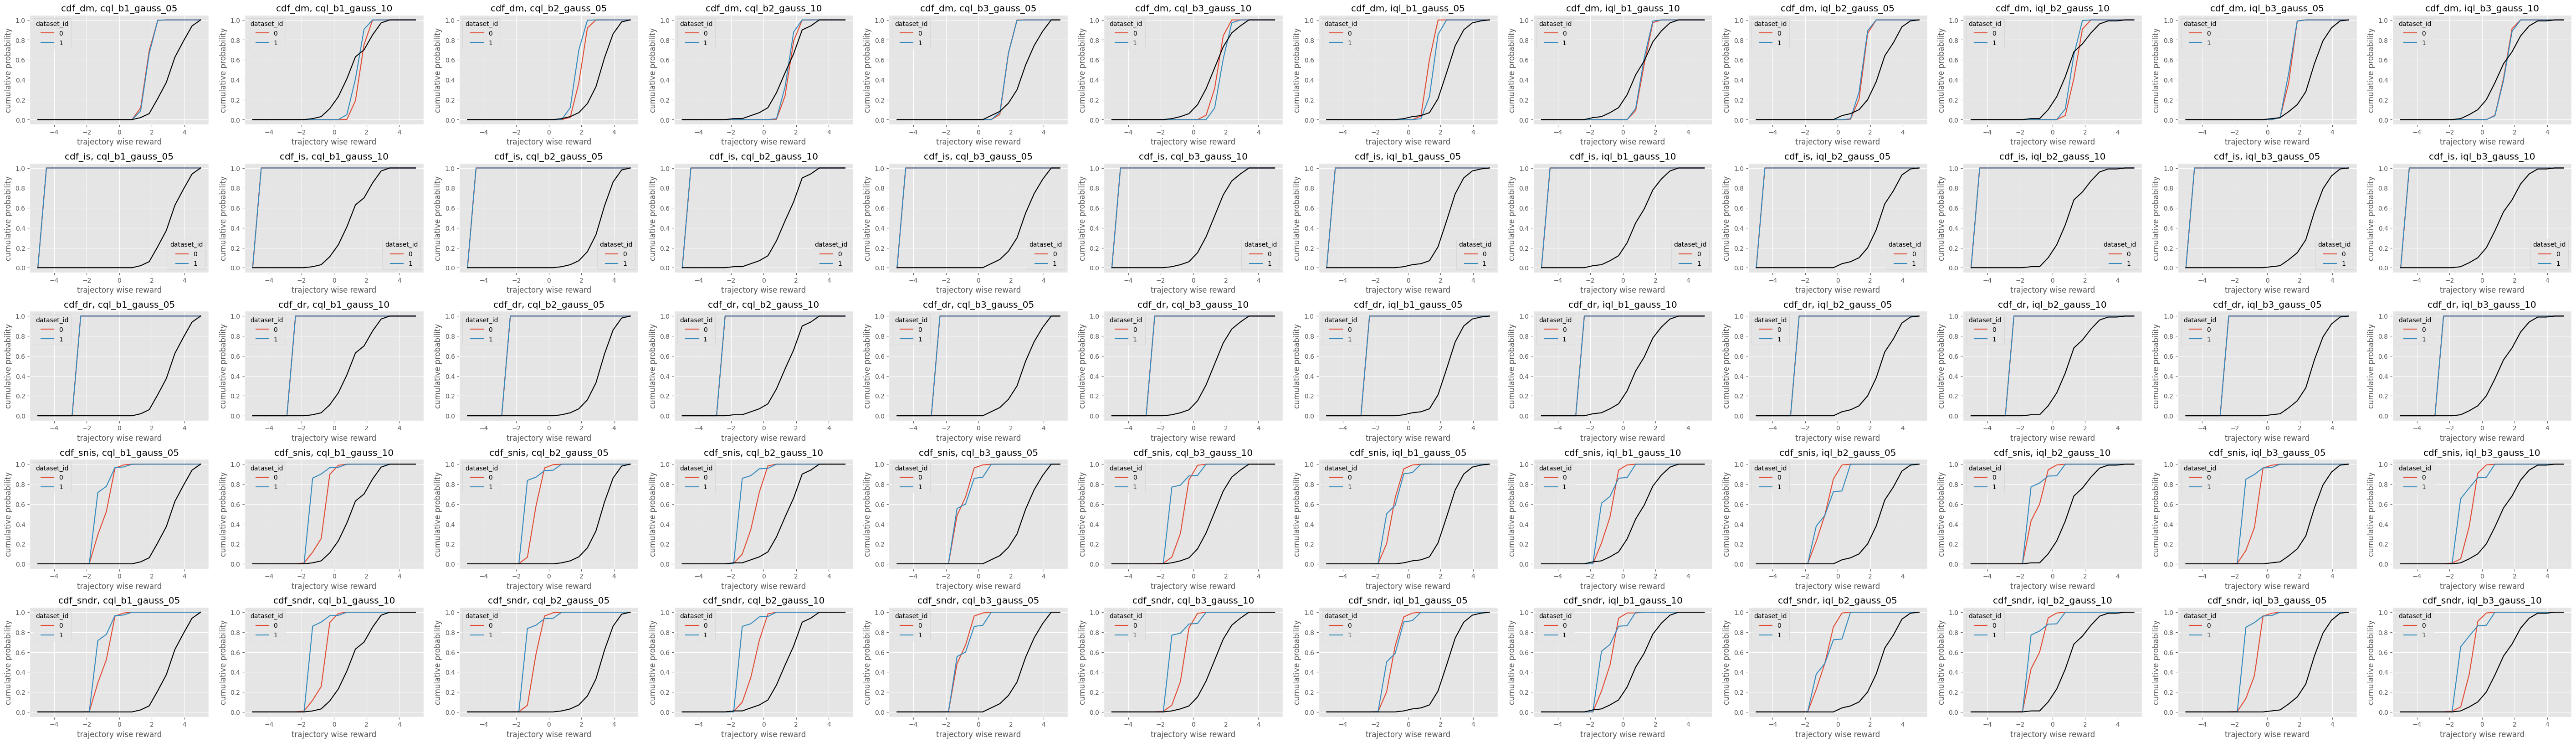

In [38]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="enumerate",
    hue="policy",
    scale_min=-5.0, 
    scale_max=5.0, 
    n_partition=20, 
)

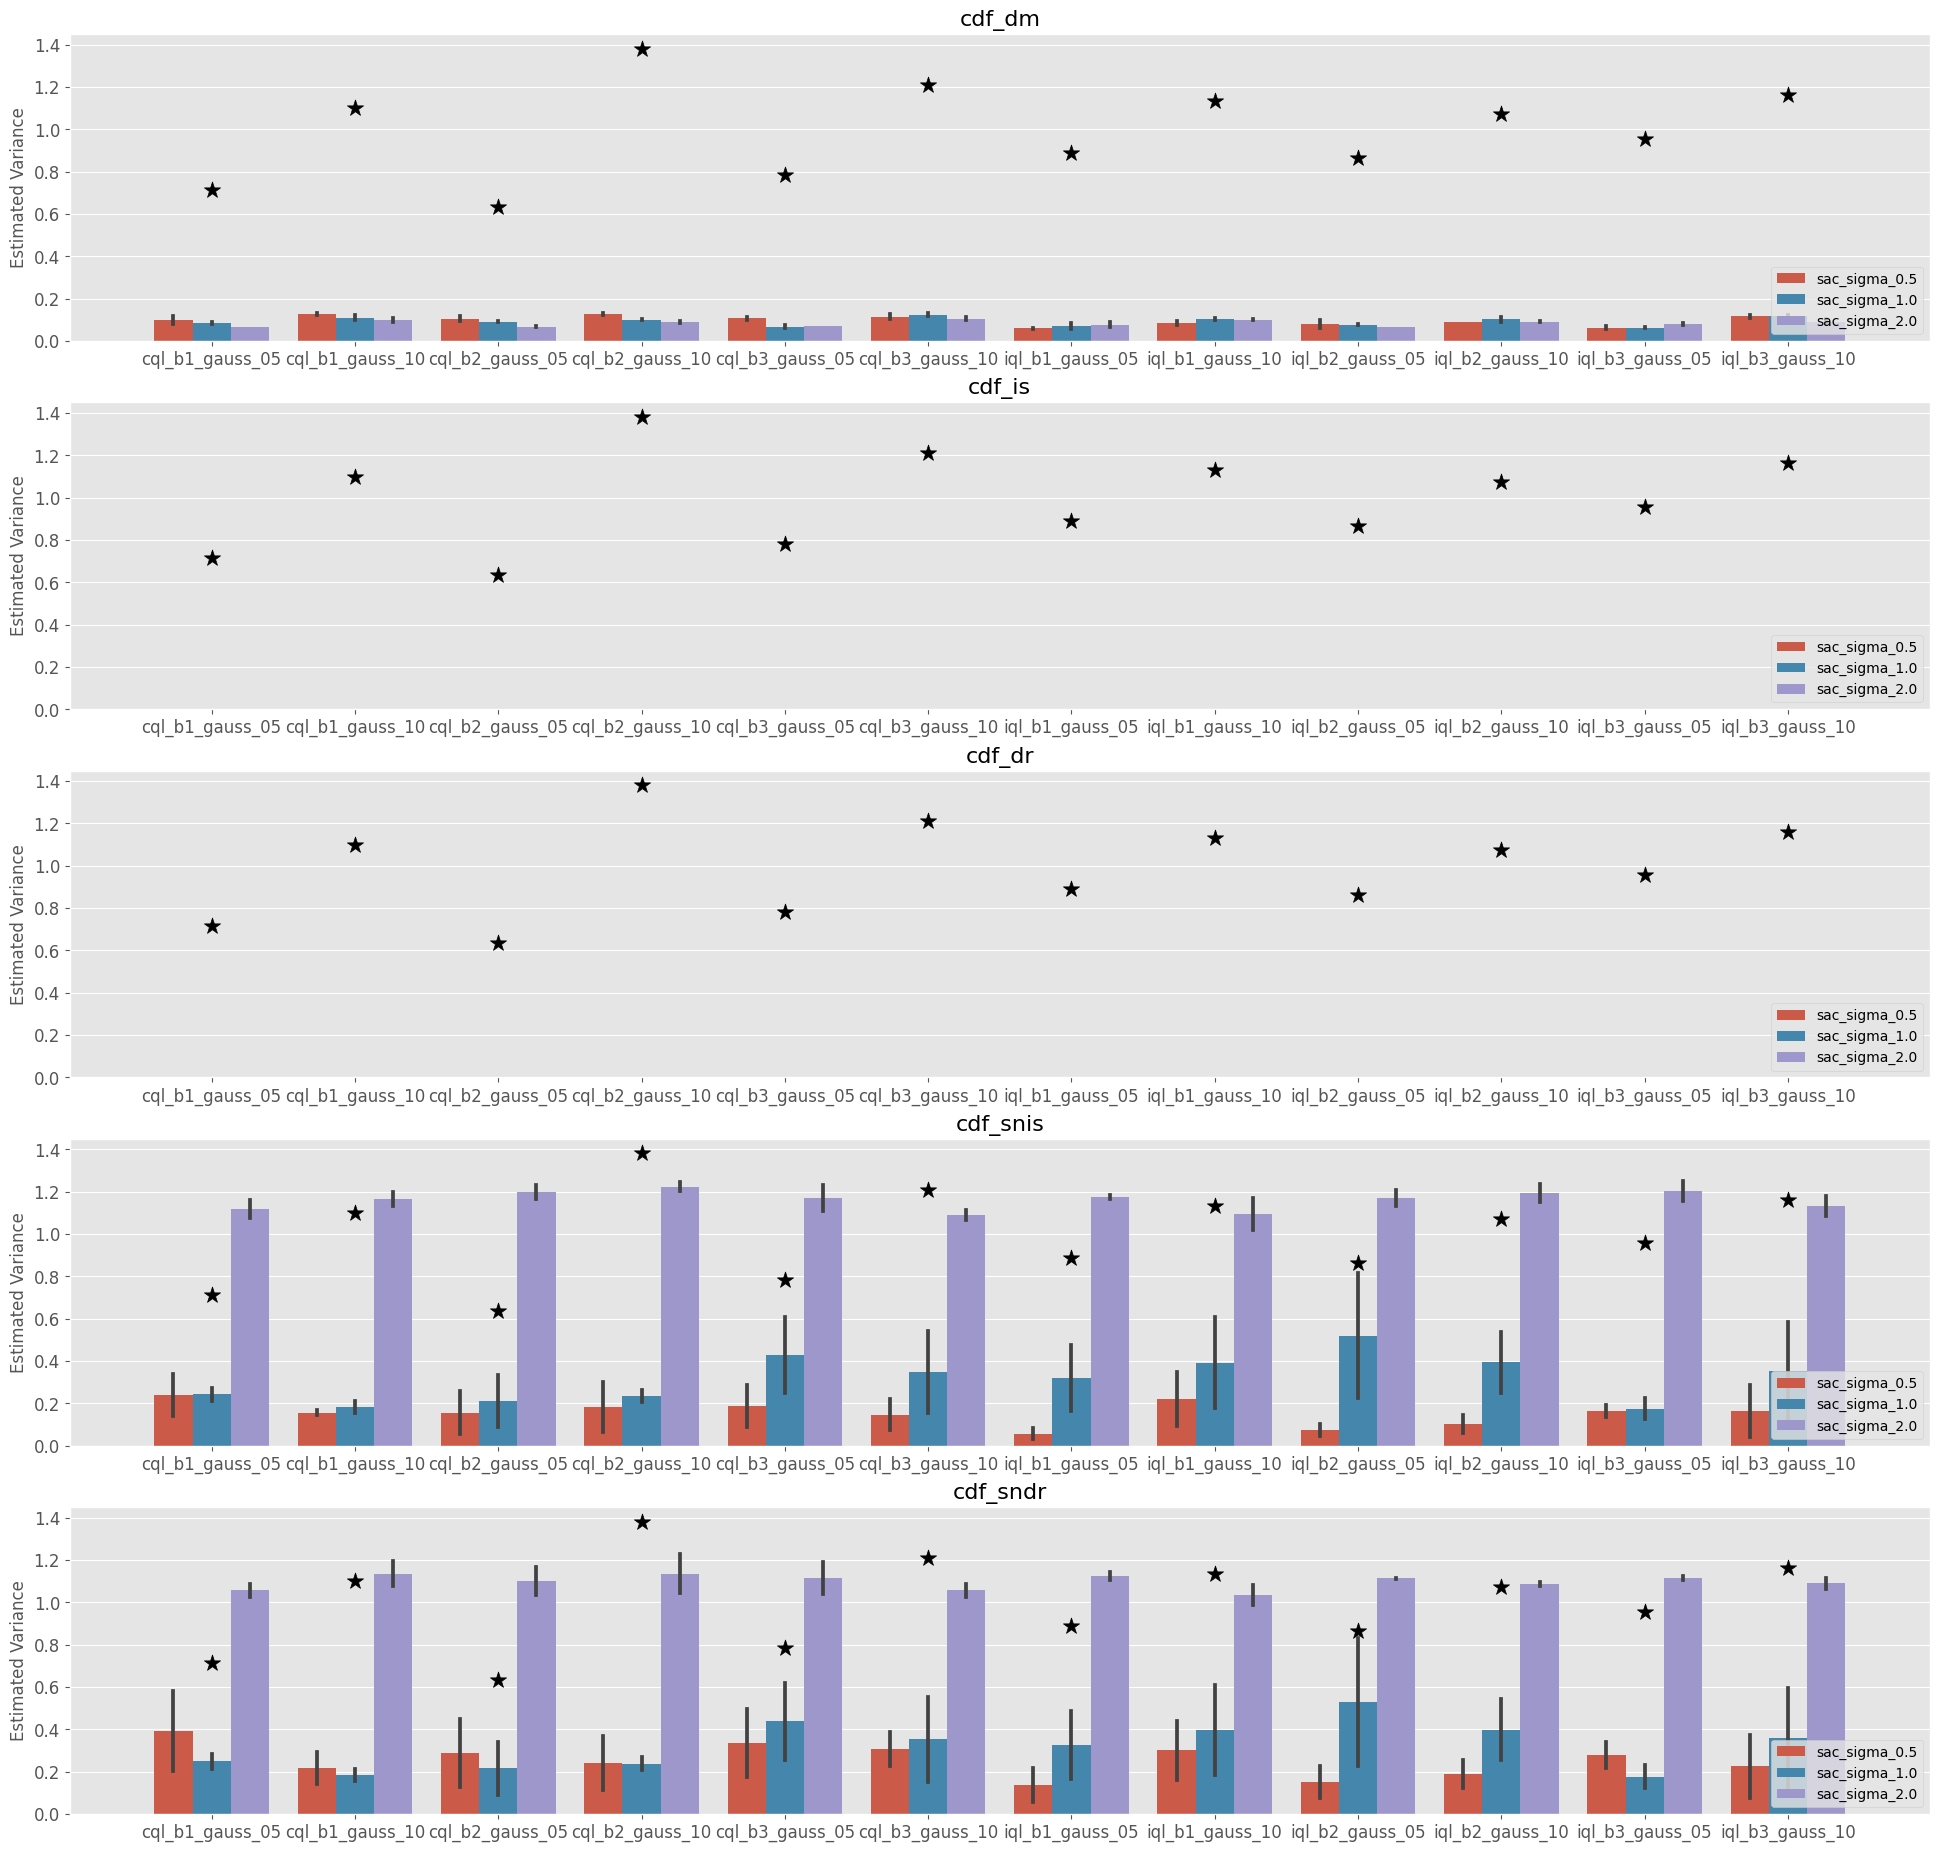

In [39]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

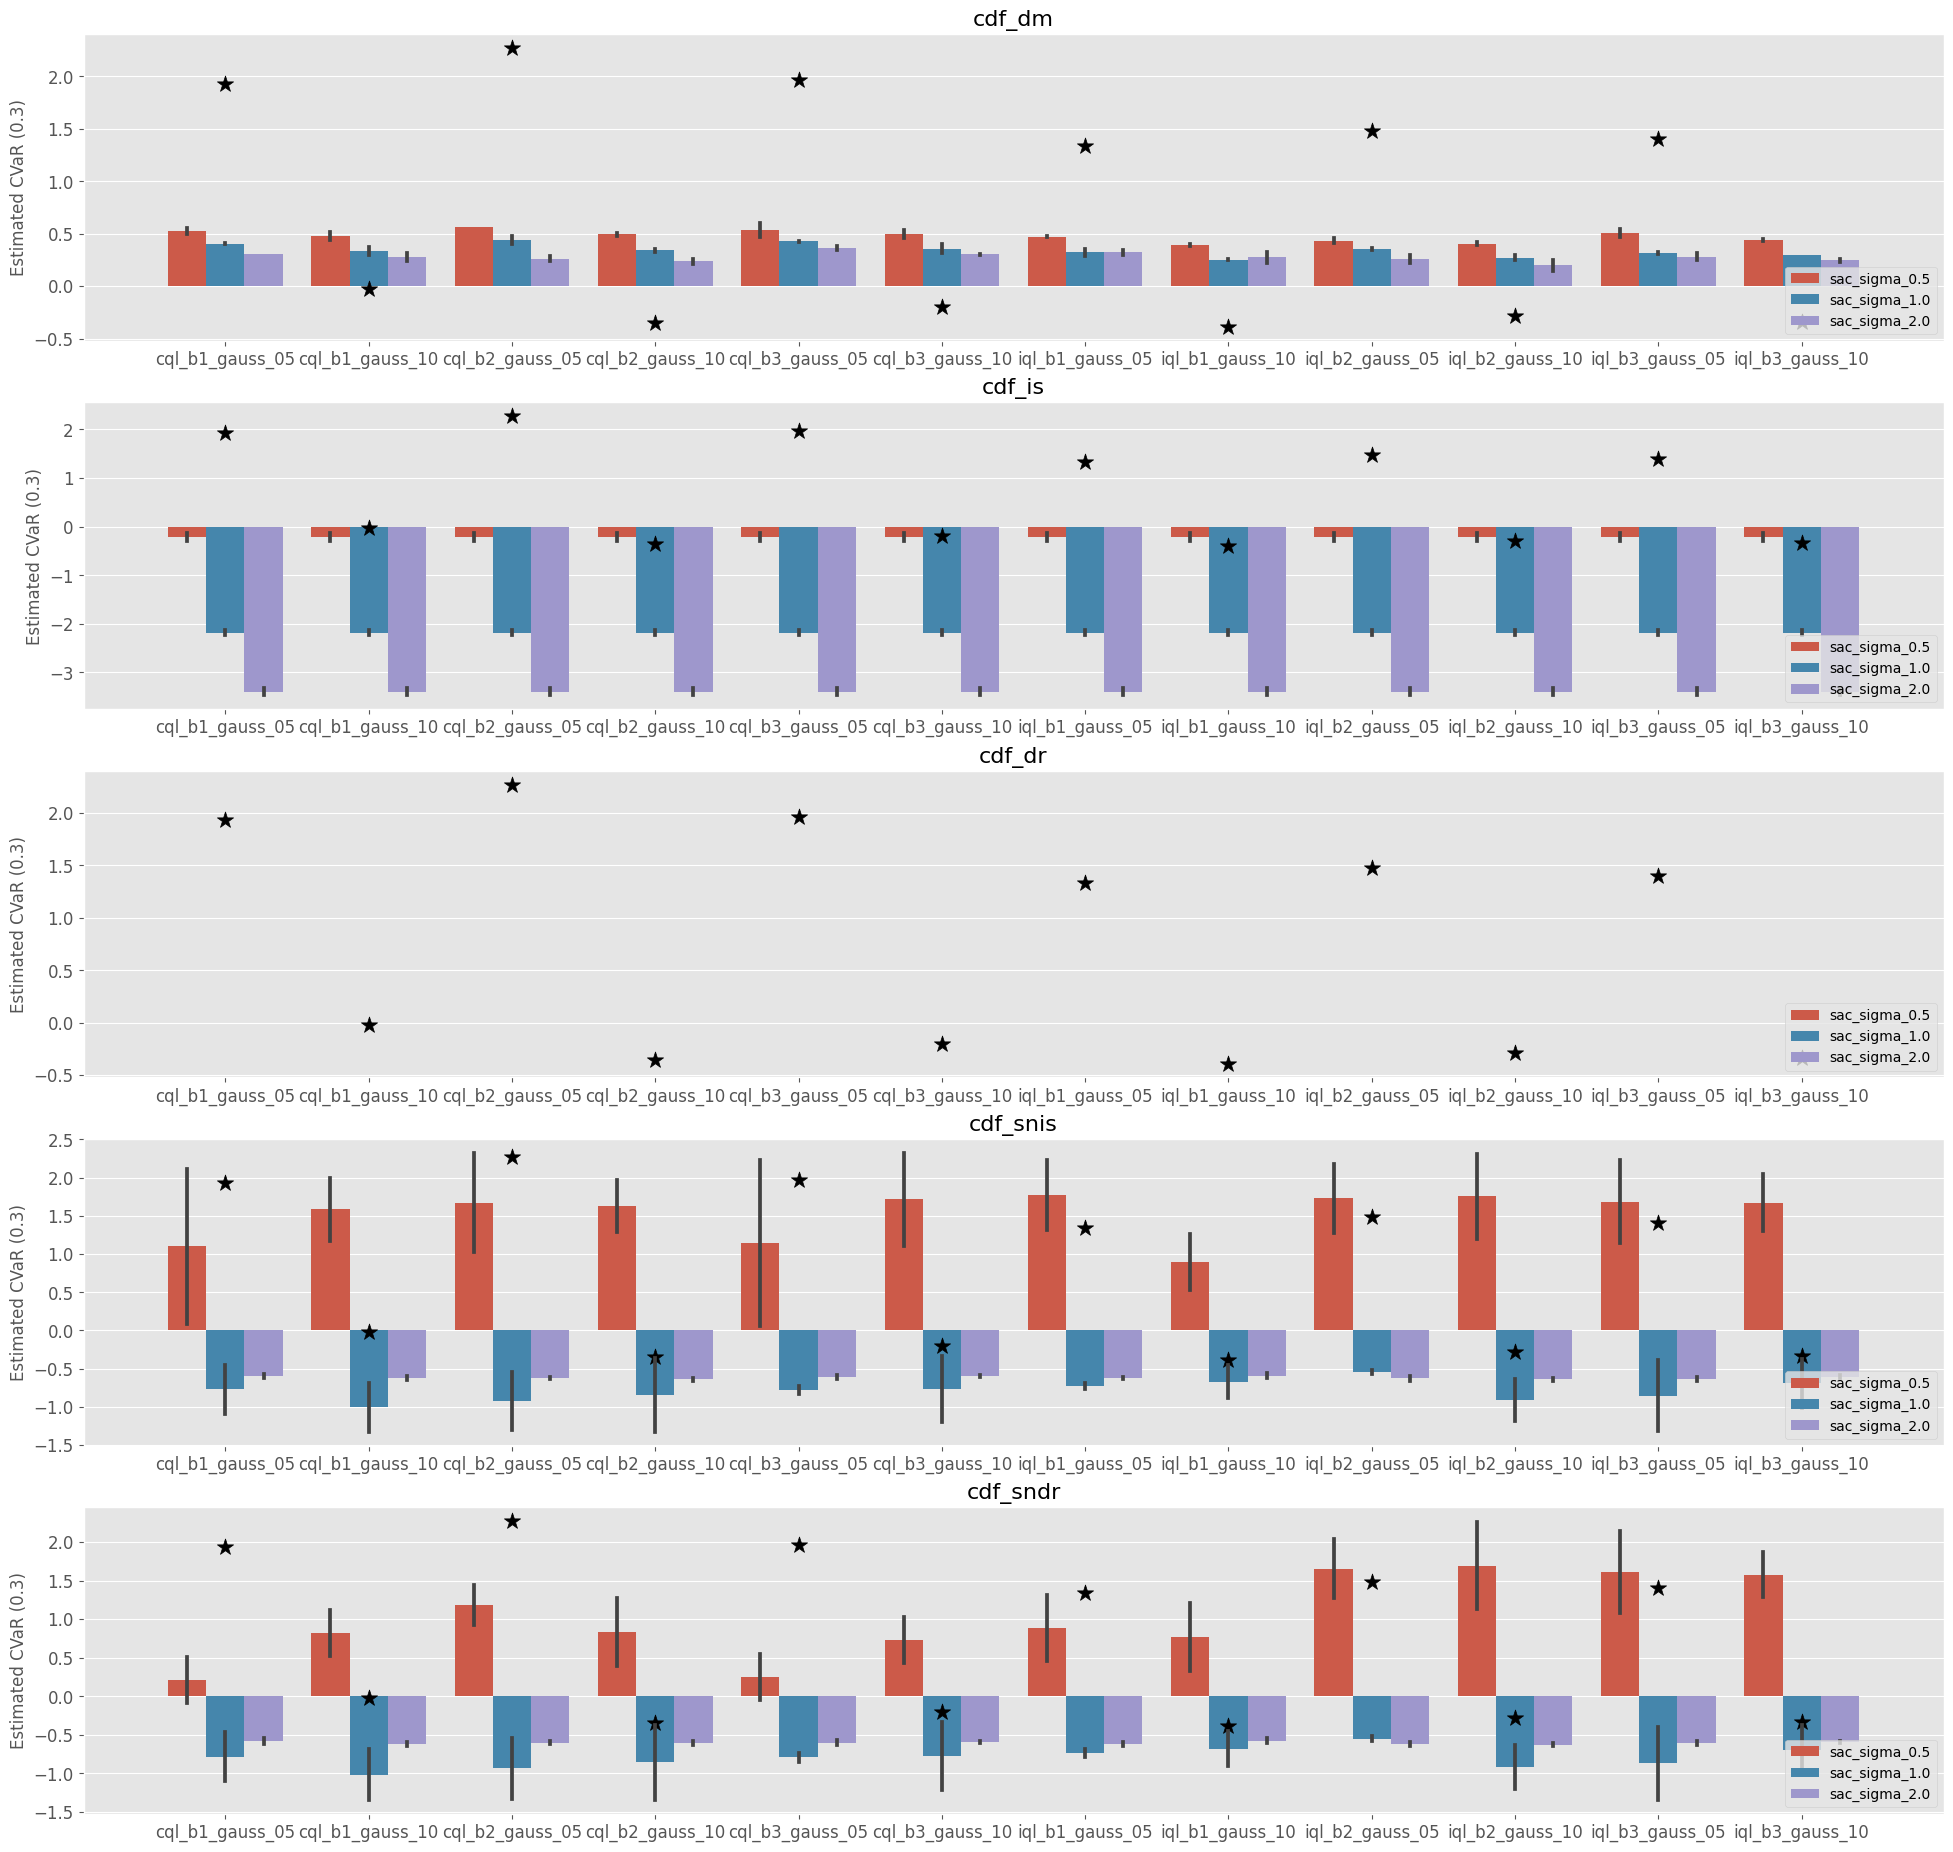

In [40]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

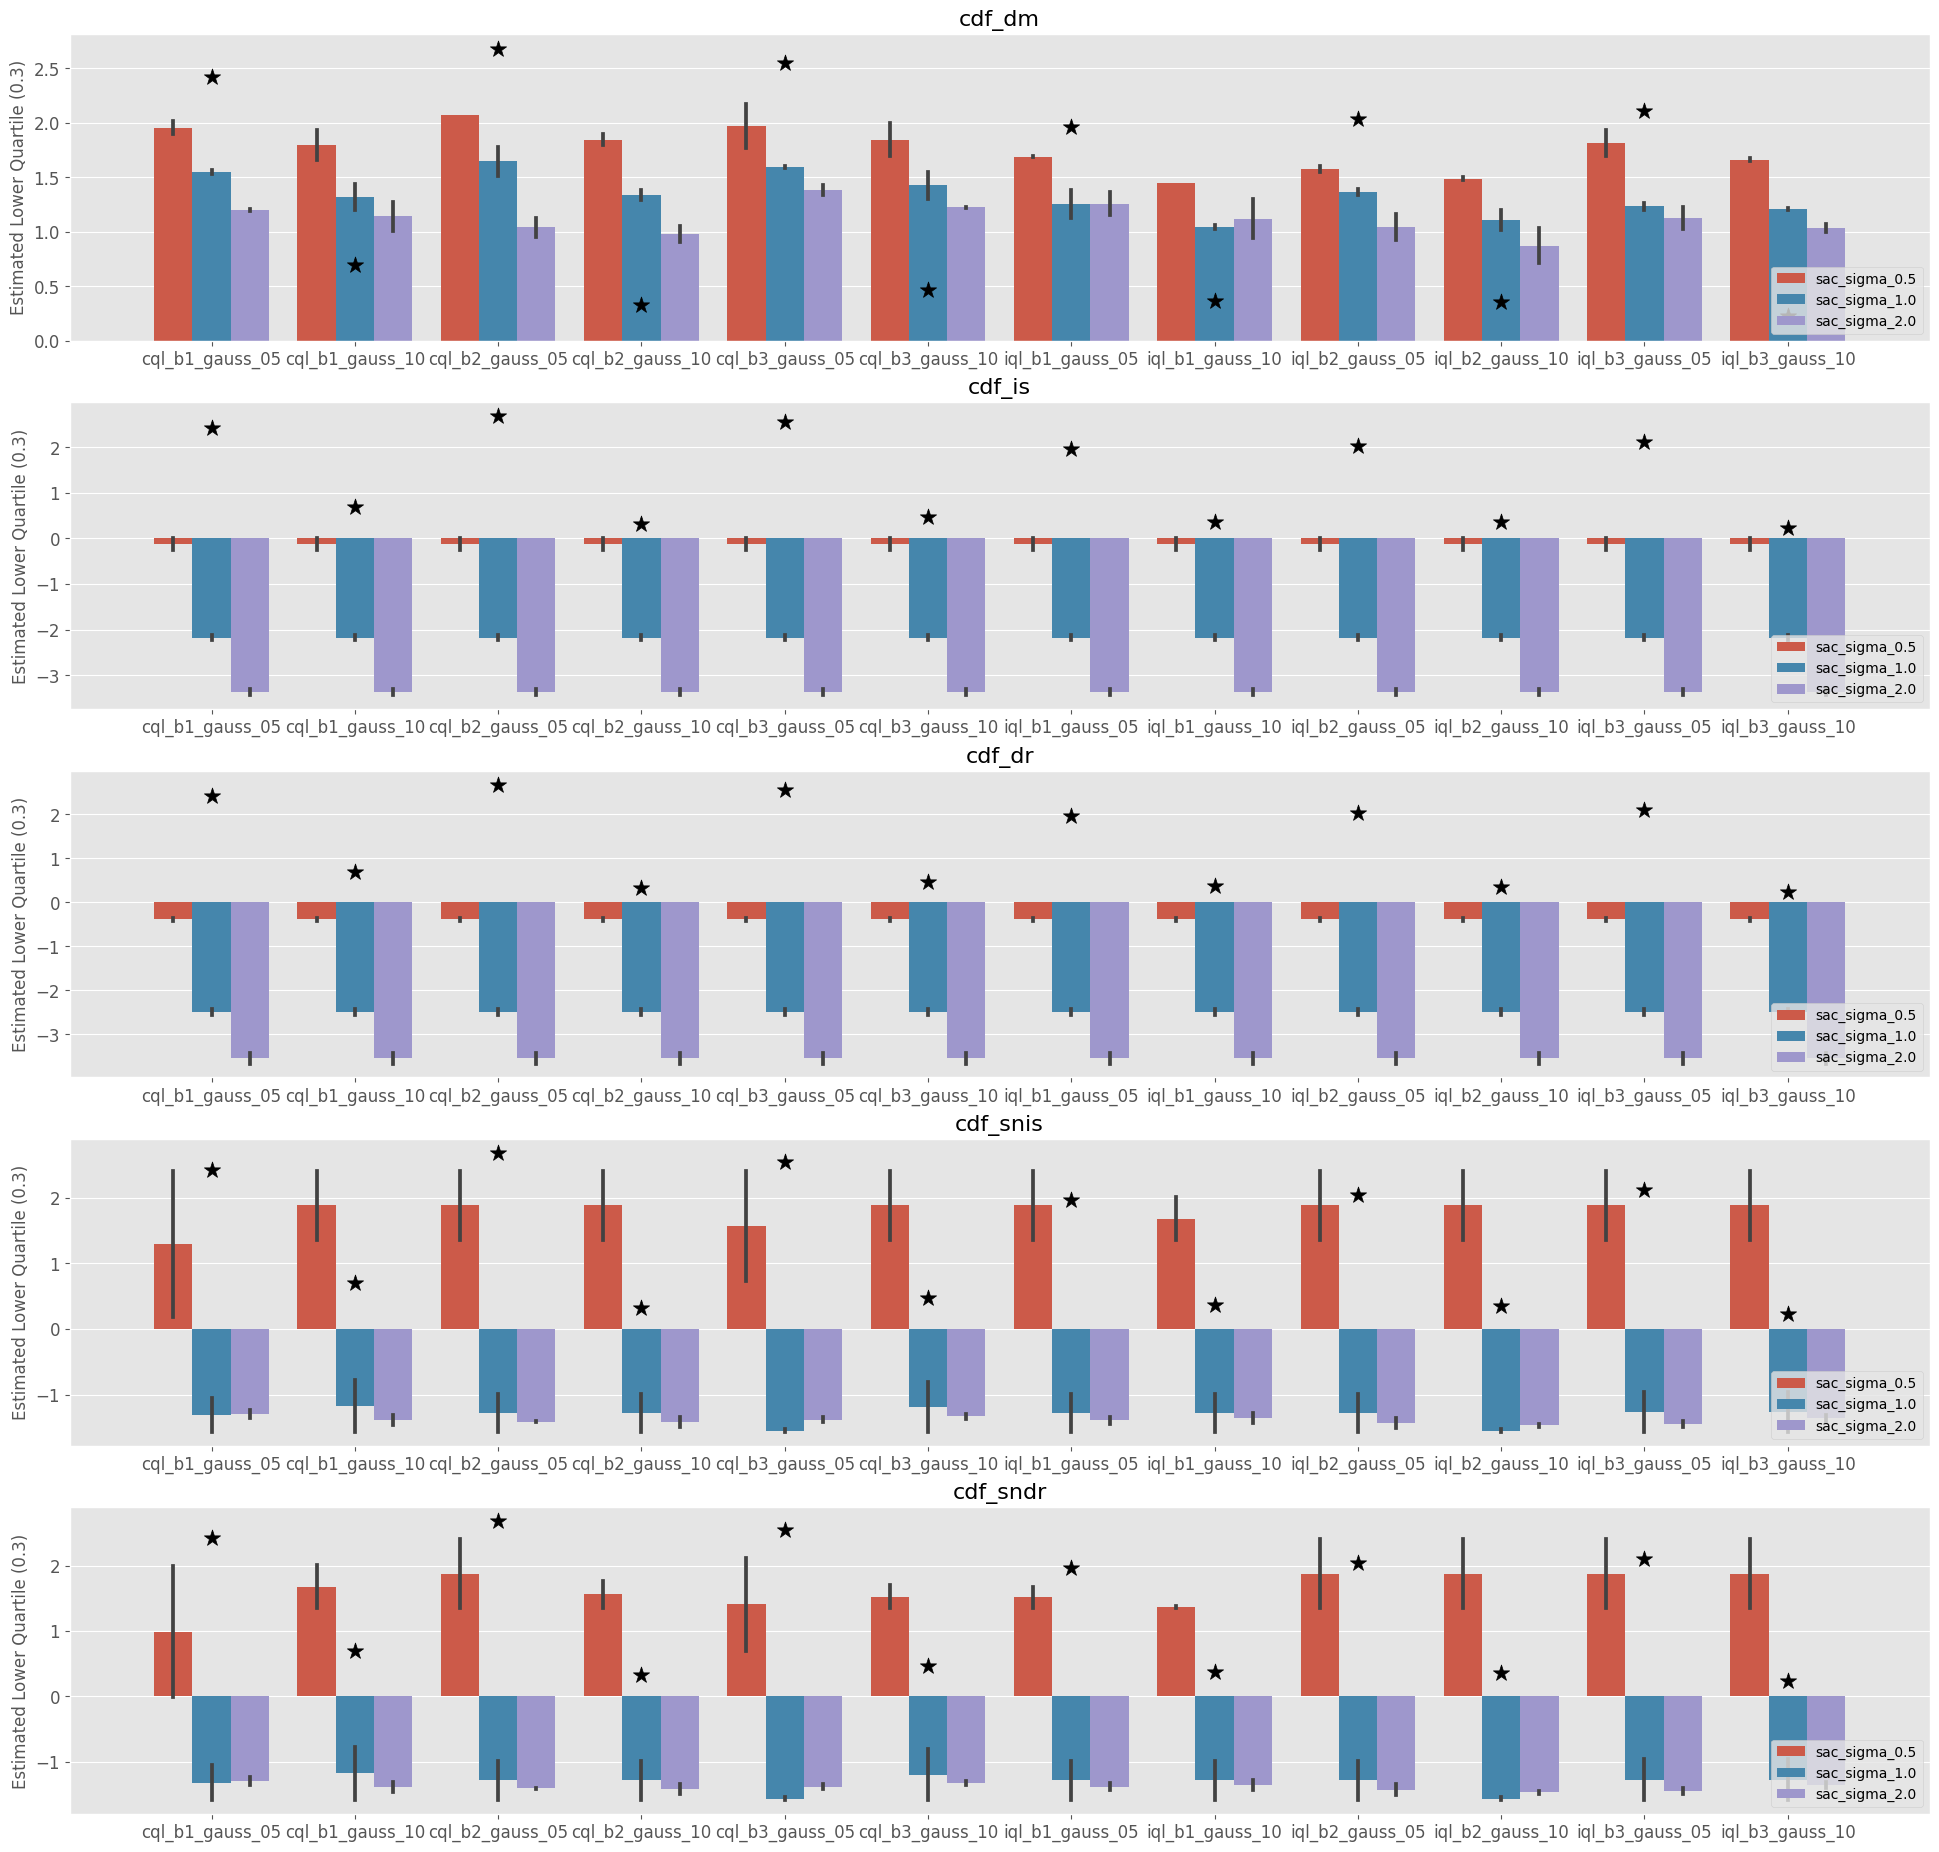

In [41]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [30]:
from ofrl.ope import OffPolicySelection

In [31]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [32]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[behavior_policies[0].name][0]

ranking  policy_value  relative_policy_value  variance  \
0   cql_b2_gauss_05      3.168800               0.898357  0.634208   
1   cql_b3_gauss_05      2.953183               0.837230  0.782404   
2   cql_b1_gauss_05      2.883189               0.817387  0.713473   
3   iql_b3_gauss_05      2.523364               0.715376  0.955815   
4   iql_b2_gauss_05      2.515059               0.713021  0.863640   
5   iql_b1_gauss_05      2.486216               0.704844  0.889086   
6   cql_b1_gauss_10      1.225472               0.347422  1.098523   
7   cql_b2_gauss_10      1.088513               0.308595  1.380899   
8   cql_b3_gauss_10      1.069442               0.303188  1.209697   
9   iql_b3_gauss_10      0.898336               0.254679  1.160803   
10  iql_b2_gauss_10      0.886994               0.251463  1.072972   
11  iql_b1_gauss_10      0.817540               0.231773  1.132309   

   ranking_by_lower_quartile  lower_quartile  \
0            cql_b1_gauss_05        1.929525   
1            cql_b1_gauss_10        1.499943   
2            cql_b2_gauss_05        1.372462   
3            cql_b2_gauss_10        0.967740   
4            cql_b3_gauss_05        0.922864   
5            cql_b3_gauss_10        0.781347   
6            iql_b1_gauss_05       -0.431820   
7            iql_b1_gauss_10       -0.631243   
8            iql_b2_gauss_05       -0.748520   
9            iql_b2_gauss_10       -0.756699   
10           iql_b3_gauss_05       -0.799256   
11           iql_b3_gauss_10       -1.119030   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                       cql_b2_gauss_05                   1.760062  
1                       cql_b1_gauss_05                   1.180811  
2                       cql_b3_gauss_05                   1.033996  
3                       iql_b1_gauss_05                   0.678788  
4                       iql_b2_gauss_05                   0.490441  
5                       iql_b3_gauss_05                   0.251374  
6                       cql_b3_gauss_10                  -0.934724  
7                       cql_b1_gauss_10                  -1.087398  
8                       cql_b2_gauss_10                  -1.230531  
9                       iql_b3_gauss_10                  -1.306067  
10                      iql_b1_gauss_10                  -1.537515  
11                      iql_b2_gauss_10                  -1.576171

In [33]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [34]:
ranking_df[behavior_policies[0].name][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0    cql_b3_gauss_05                2.349019                         0.665949   
 1    cql_b2_gauss_05                2.269331                         0.643357   
 2    cql_b1_gauss_05                2.166604                         0.614234   
 3    cql_b1_gauss_10                2.119889                         0.600990   
 4    cql_b2_gauss_10                2.004692                         0.568332   
 5    cql_b3_gauss_10                1.891611                         0.536273   
 6    iql_b3_gauss_10                1.838556                         0.521232   
 7    iql_b1_gauss_05                1.832555                         0.519531   
 8    iql_b3_gauss_05                1.812533                         0.513855   
 9    iql_b2_gauss_05                1.744769                         0.494644   
 10   iql_b2_gauss_10                1.655605                         0.469365   
 11   iql_

In [35]:
metric_df[behavior_policies[0].name][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm        6.367968e-01          0.678322  0.015317  0.215616   
1       tis        1.433080e+53          0.412587  0.182564  0.645435   
2      pdis        2.813777e+47         -0.118881  0.712884  1.943327   
3        dr        1.179793e+53         -0.461538  0.130948  2.351260   
4     sntis        9.370580e-01          0.447552  0.144586  0.653741   
5    snpdis        6.423560e+00          0.692308  0.012593  0.285611   
6      sndr        2.324291e+00          0.174825  0.586824  0.000000   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 0.0  
1           0.000000                 0.0  
2           0.000000                 0.0  
3           1.000000                 0.0  
4           0.000000                 0.0  
5           1.000000                 0.0  
6           0.166667                 0.0

In [36]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    safety_threshold=2.0,
    return_by_dataframe=True,
)

In [37]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  2.659153  2.659153  2.659153  2.659153       NaN   
1         dm     1  2.038743  2.981757  1.716139  2.348948  0.894927   
2         dm     2  2.456476  3.045623  1.699329  2.384791  0.742414   
3         dm     3  2.024316  3.071044  1.135980  2.294672  0.941724   
4         dm     4  2.244341  3.071044  1.113153  2.284606  0.919283   
5         dm     5  2.531971  3.124444  1.109975  2.325833  0.876350   
6         dm     6  1.346224  3.124444  1.011062  2.185889  0.911259   
7         dm     7  1.257782  3.124444  0.889963  2.069876  0.942274   
8         dm     8  1.879926  3.124444  0.889963  2.048770  0.914620   
9         dm     9  2.040227  3.124444  0.889963  2.047916  0.896753   
10        dm    10  1.598937  3.146220  0.880608  2.007100  0.914660   
11        dm    11  1.220938  3.146220  0.859827  1.941586  0.918177   
0        tis     0  2.551139  2.551139  2.551139  2.551139       NaN   
1        tis     1  2.570888  2.622789  2.499237  2.561013  0.087364   
2        tis     2  2.080658  2.622789  2.063245  2.400895  0.299950   
3        tis     3  1.769932  3.048949  1.308839  2.243154  0.846867   
4        tis     4  1.503018  3.048949  1.037158  2.095127  0.954158   
5        tis     5  1.448793  3.048949  0.986286  1.987405  0.941375   
6        tis     6  1.320486  3.048949  0.913402  1.892130  0.927663   
7        tis     7  1.949917  3.048949  0.880608  1.899354  0.924608   
8        tis     8  1.076693  3.048949  0.871403  1.807947  0.908650   
9        tis     9  2.419000  3.126355  0.871403  1.869052  0.920658   
10       tis    10  2.184860  3.126355  0.871403  1.897762  0.918791   
11       tis    11  2.423649  3.146220  0.859827  1.941586  0.918177   
0       pdis     0  1.890432  1.890432  1.890432  1.890432       NaN   
1       pdis     1  2.526239  2.560123  1.856548  2.208336  0.497503   
2       pdis     2  2.660380  3.016732  1.638508  2.359017  0.750727   
3       pdis     3  1.845627  3.016732  1.291072  2.230670  0.808673   
4       pdis     4  1.306688  3.016732  0.970358  2.045873  0.920268   
5       pdis     5  1.727183  3.016732  0.970358  1.992758  0.934175   

    safety_violation_rate  sharpe_ratio  
0                0.166667           NaN  
1                0.333333      2.001524  
2                0.333333      2.497092  
3                0.375000      1.474052  
4                0.366667      1.584039  
5                0.333333      1.728282  
6                0.404762      1.649446  
7                0.458333      1.572754  
8                0.462963      1.606462  
9                0.450000      1.604566  
10               0.469697      1.607736  
11               0.500000      1.609715  
0                0.166667           NaN  
1                0.166667     11.711841  
2                0.222222      6.208274  
3                0.333333      1.575899  
4                0.433333      1.512710  
5                0.500000      1.506465  
6                0.547619      1.524766  
7                0.541667      1.514302  
8                0.592593      1.540096  
9                0.550000      1.553278  
10               0.530303      1.576264  
11               0.500000      1.609715  
0                0.500000           NaN  
1                0.333333      6.063175  
2                0.277778      4.237755  
3                0.333333      1.673599  
4                0.433333      1.517850  
5                0.472222      1.517201

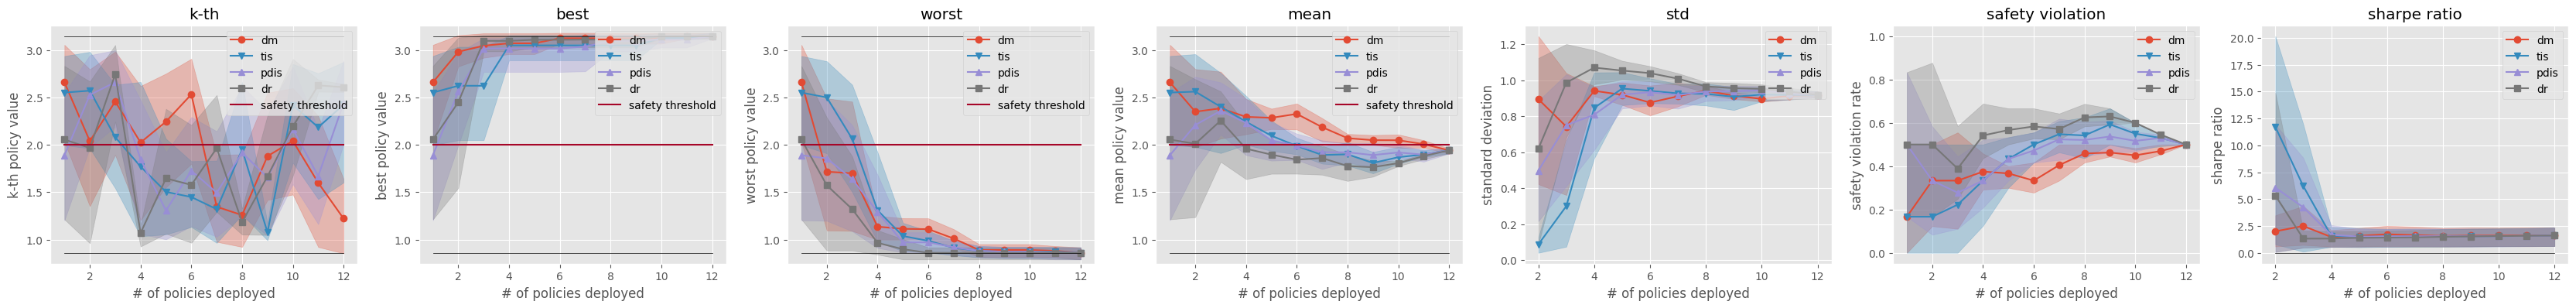

In [38]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_threshold=2.0,
    legend=True,
    random_state=random_state,
)

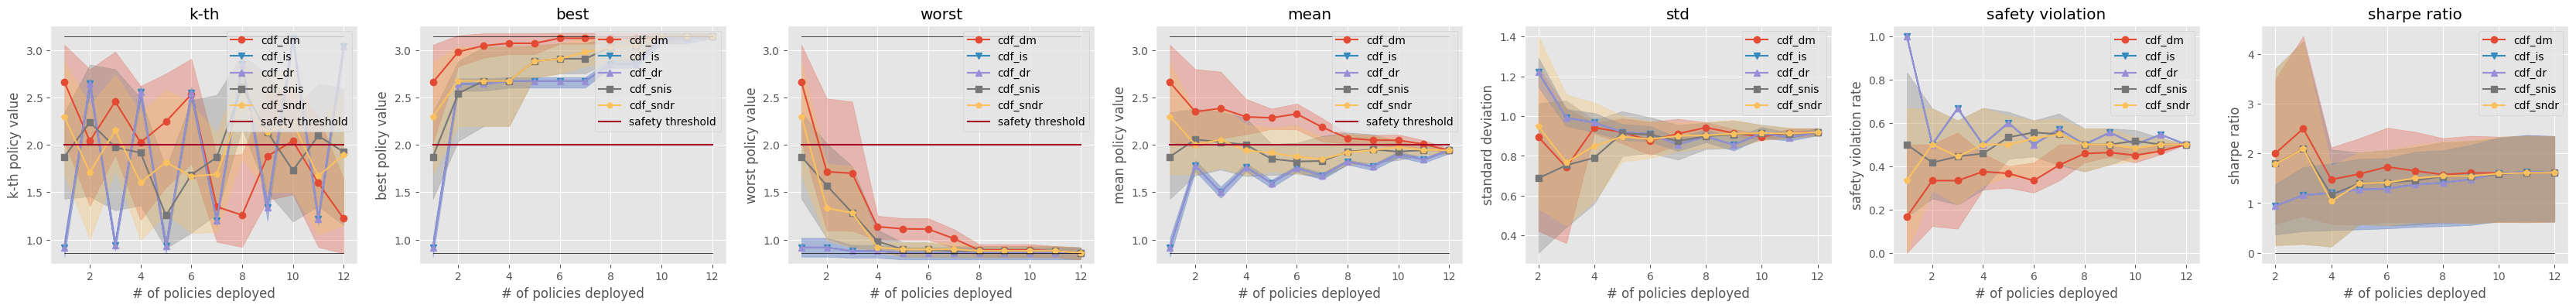

In [39]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_threshold=2.0,
    legend=True,
    random_state=random_state,
)

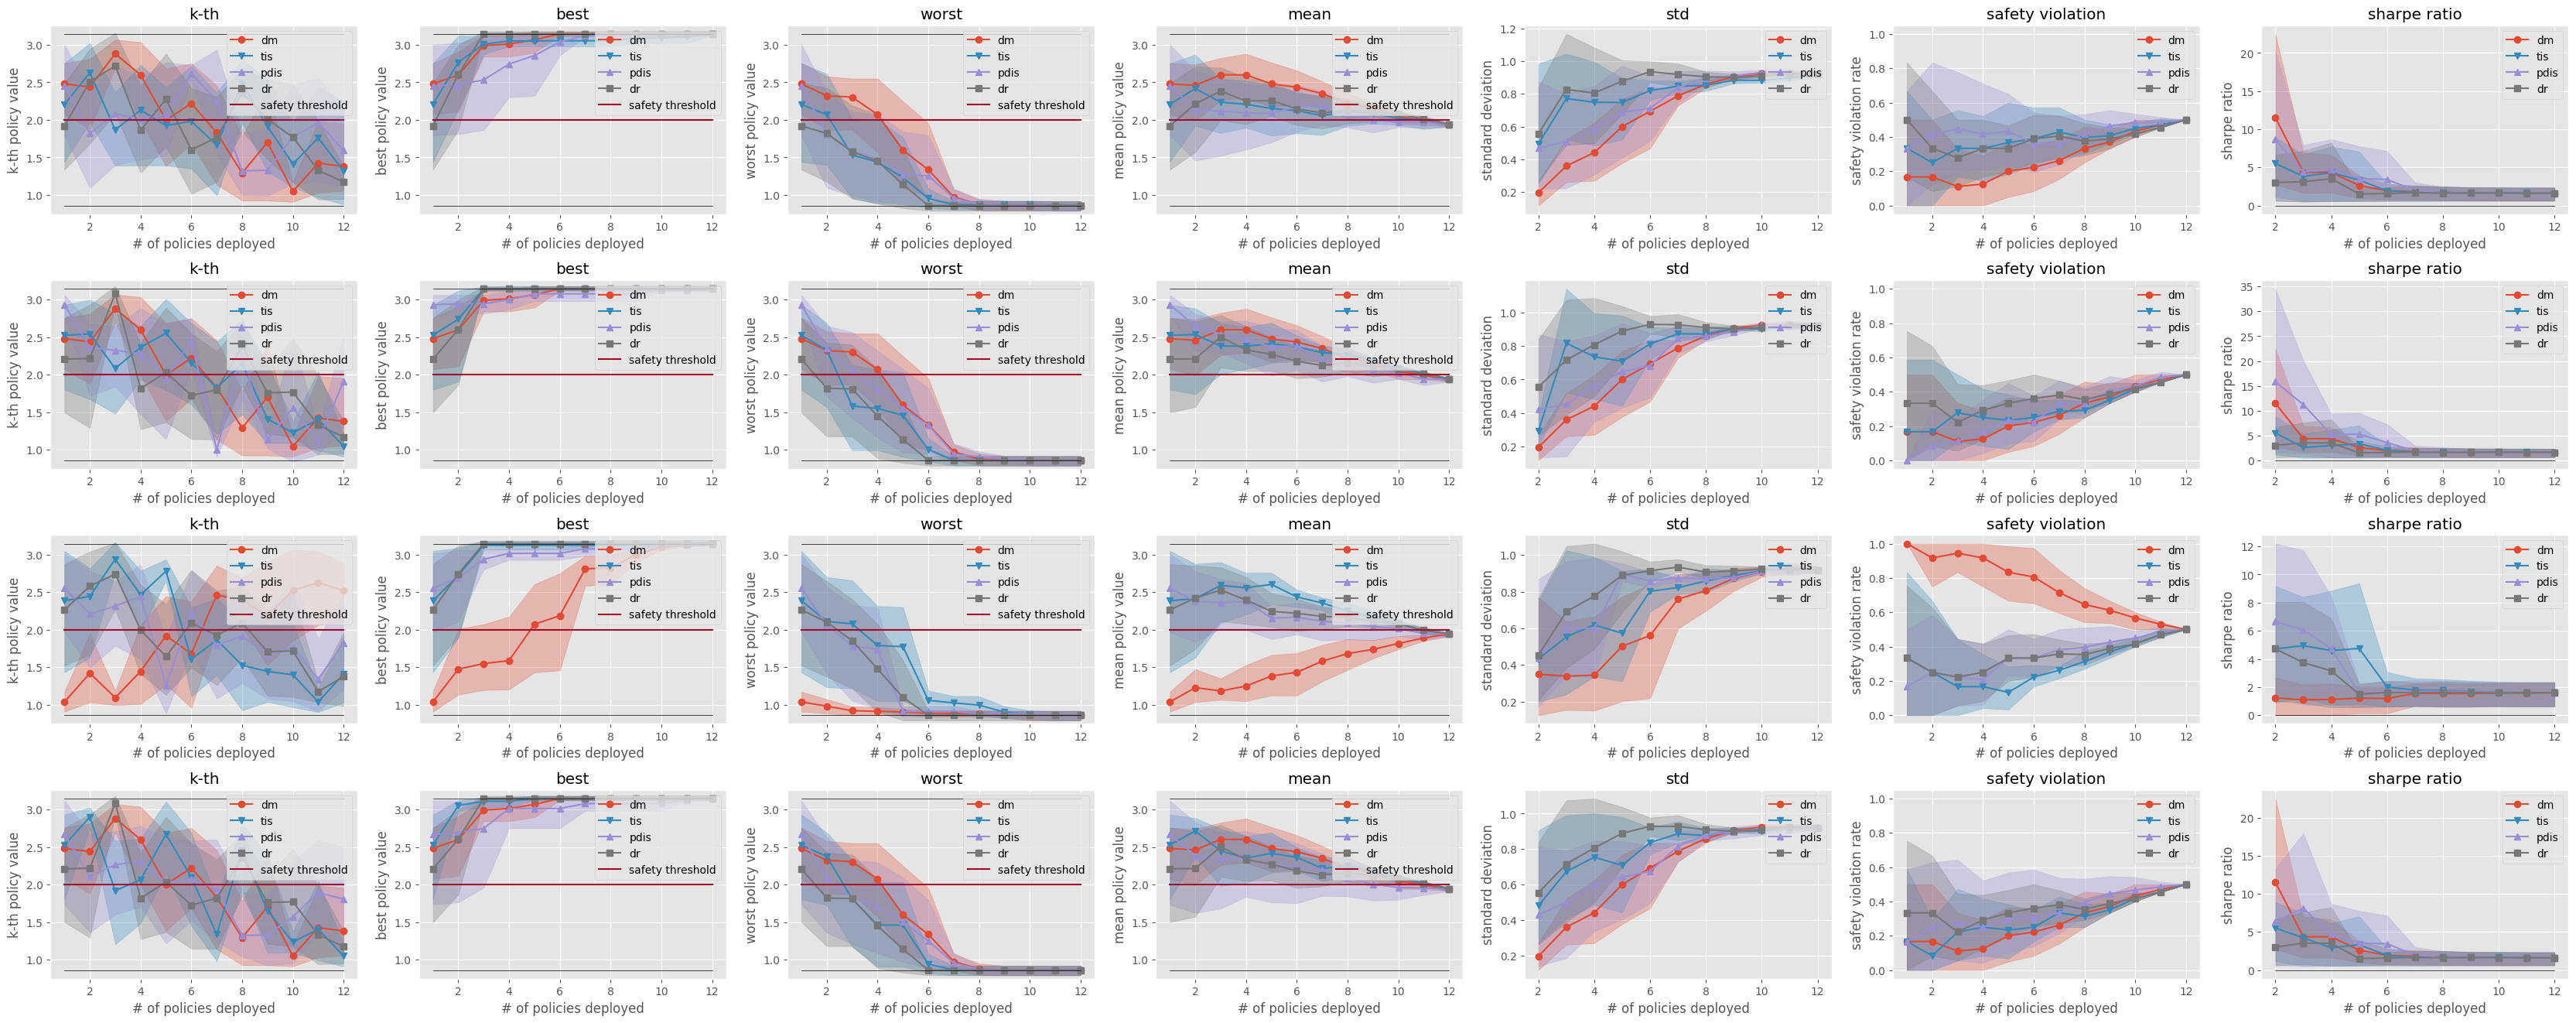

In [40]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_threshold=2.0,
    legend=True,
    random_state=random_state,
)

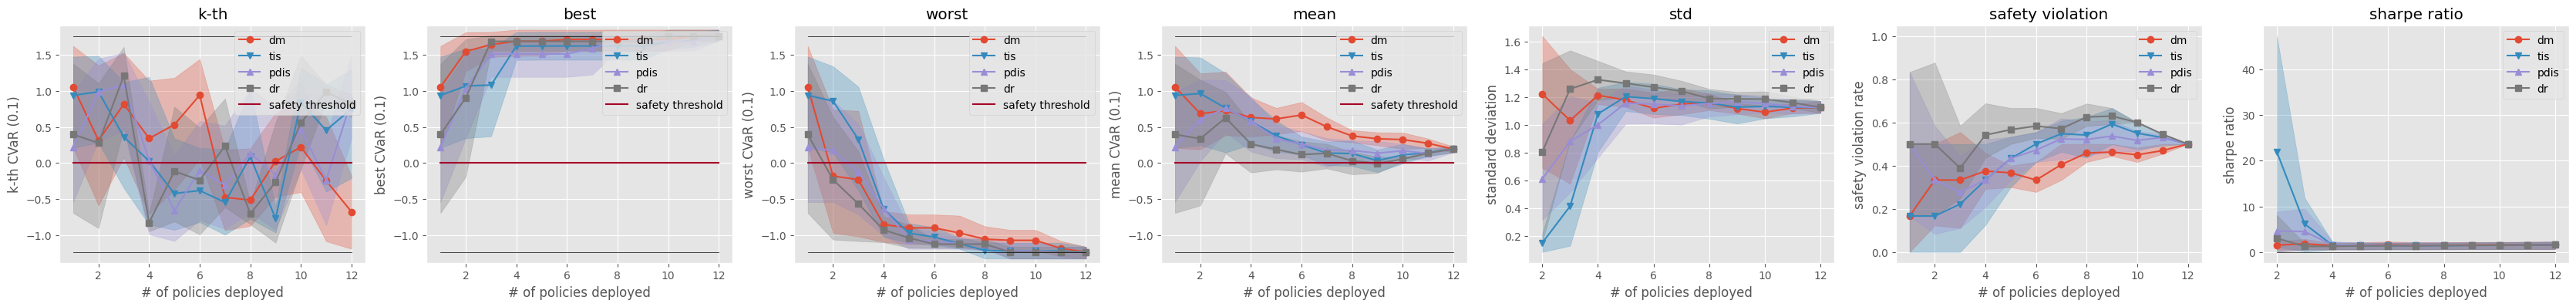

In [41]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    legend=True,
    random_state=random_state,
)

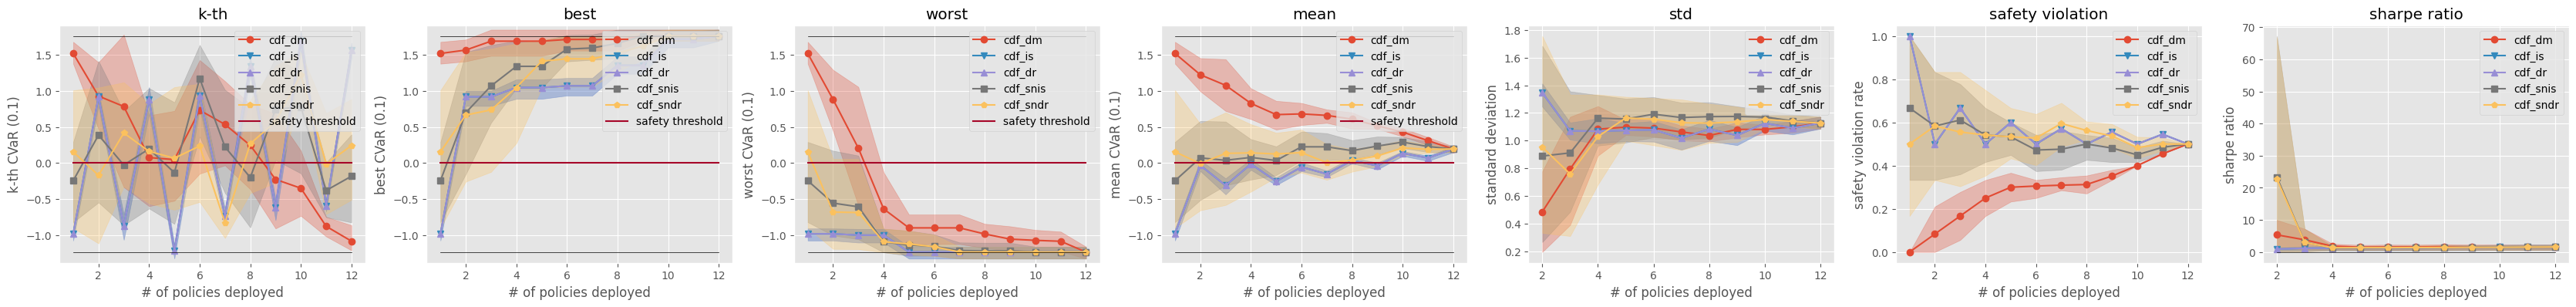

In [42]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    legend=True,
    random_state=random_state,
)

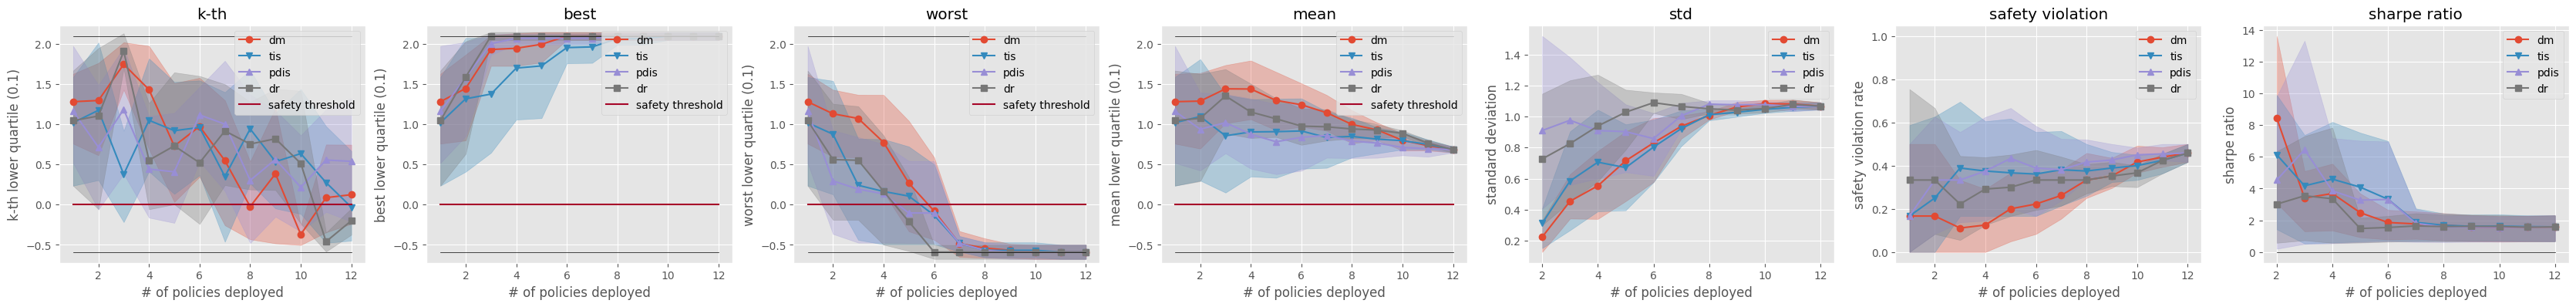

In [43]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    legend=True,
    random_state=random_state,
)

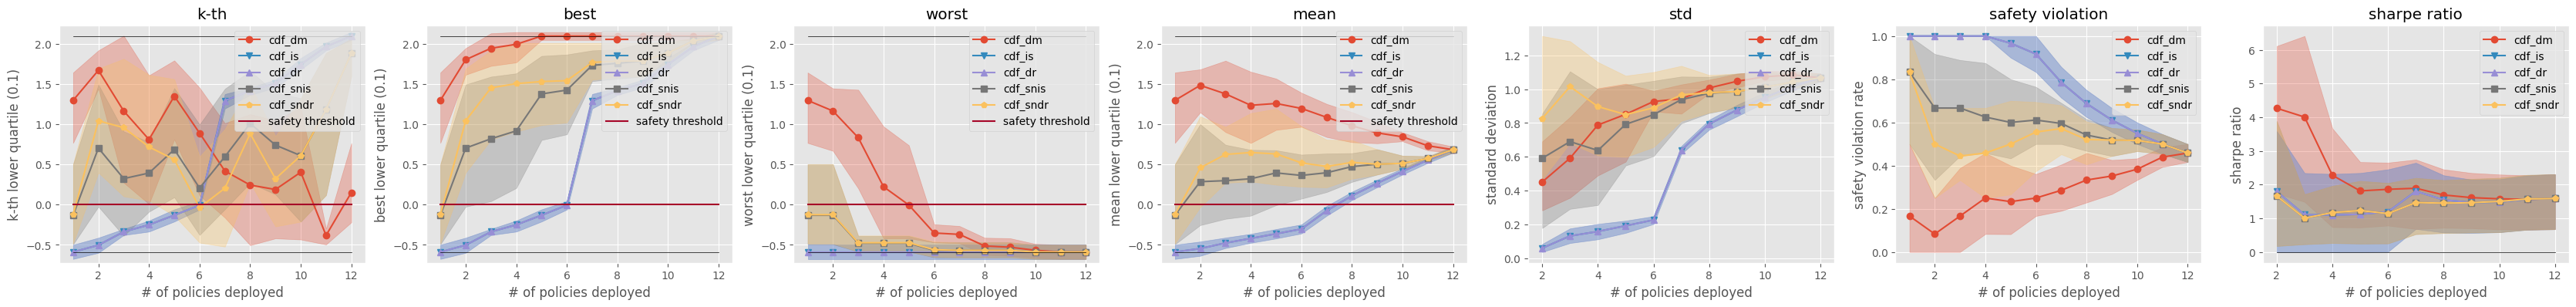

In [44]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    legend=True,
    random_state=random_state,
)

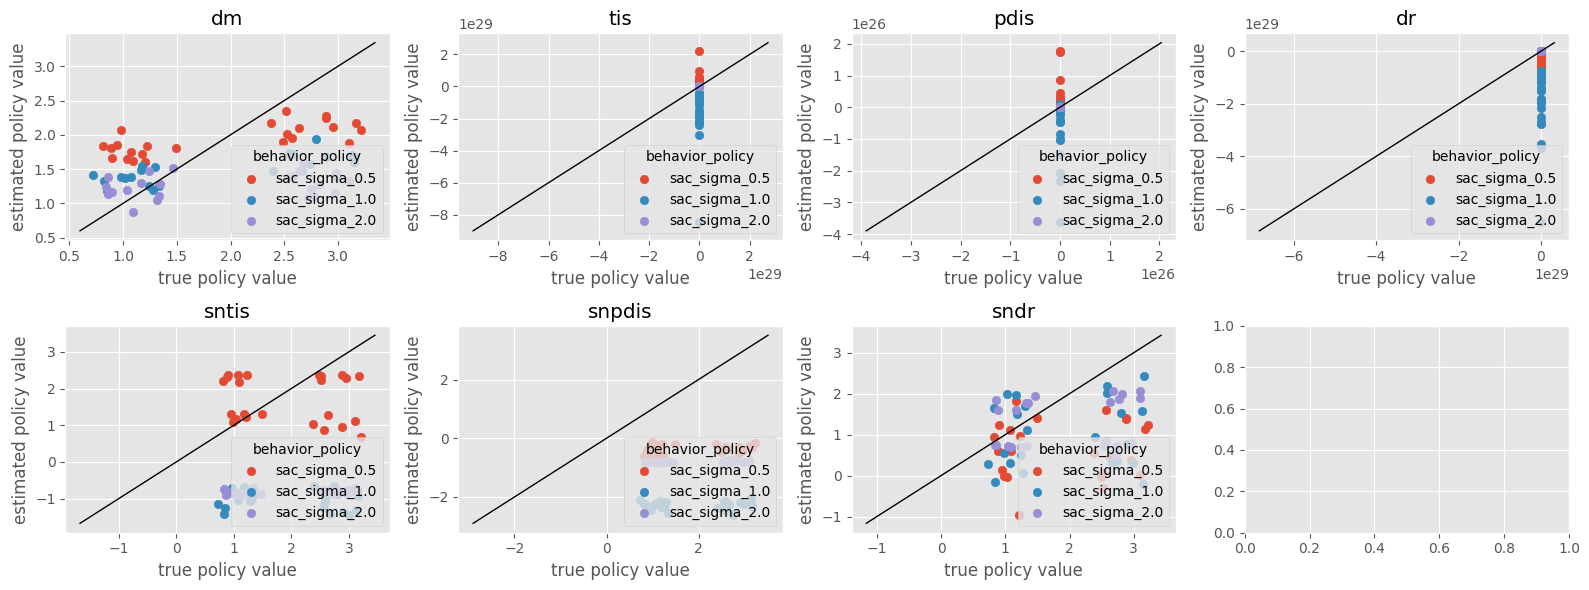

In [45]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=False,
)

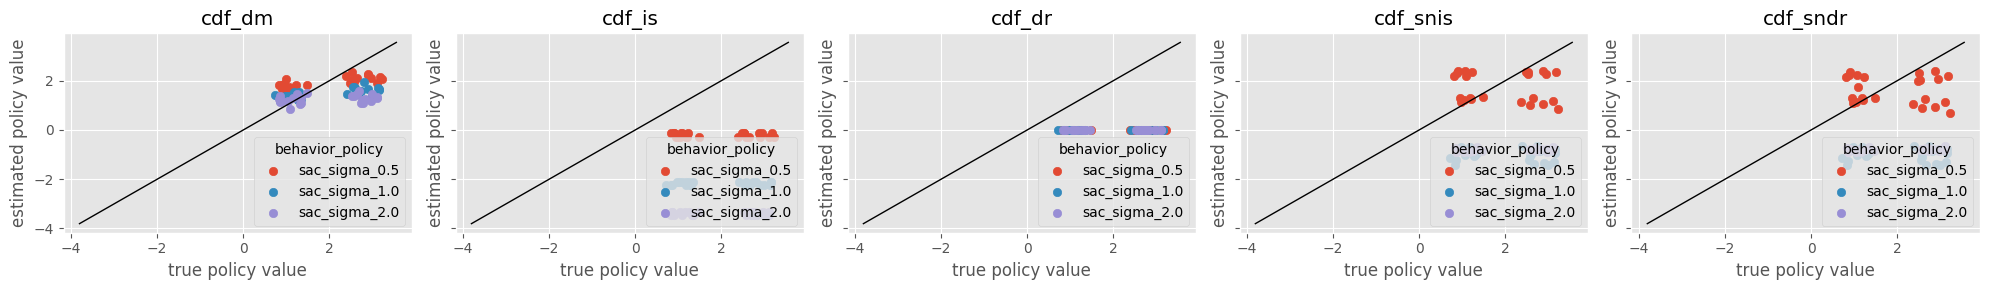

In [46]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

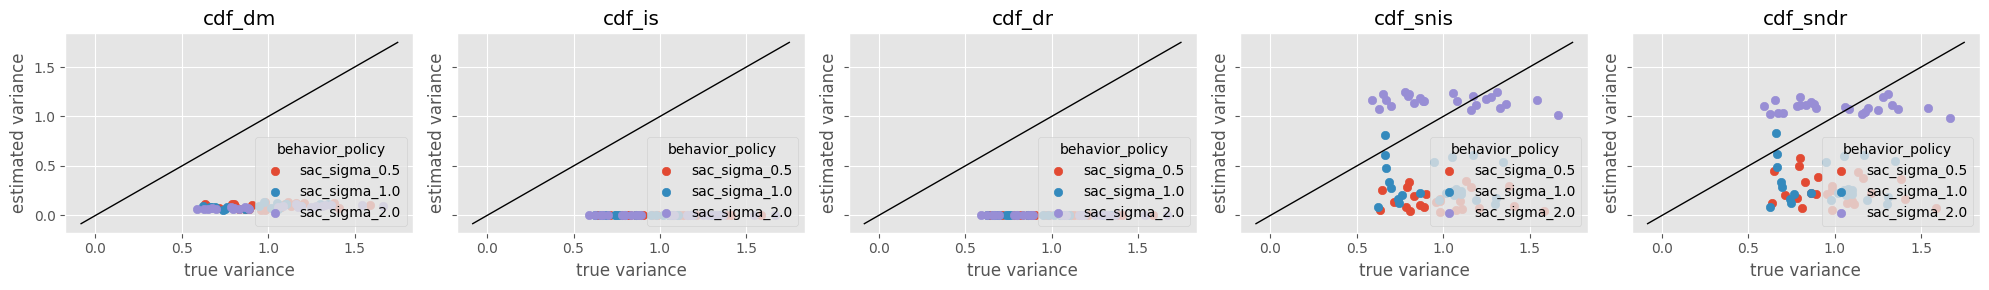

In [47]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

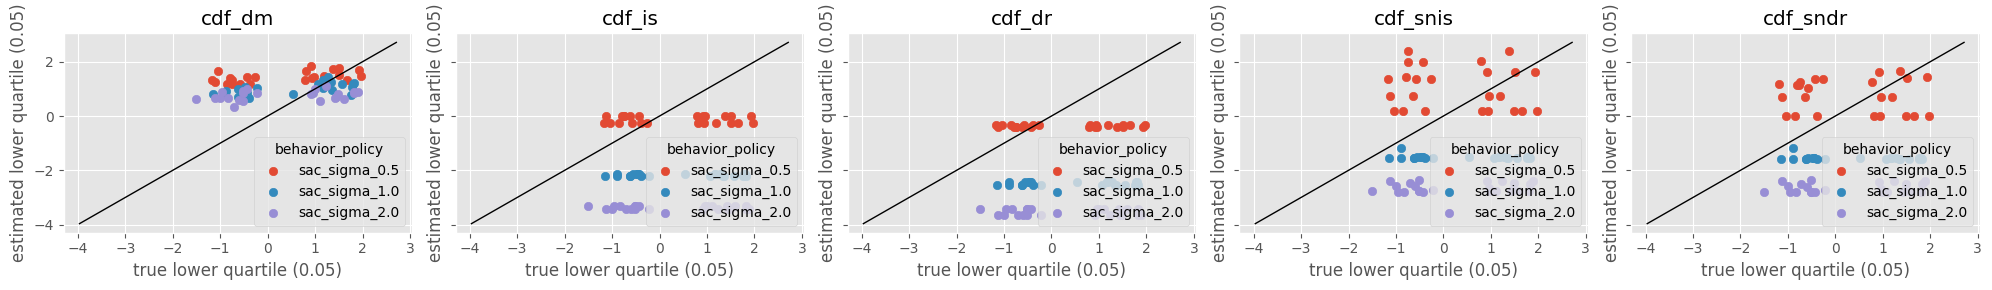

In [48]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

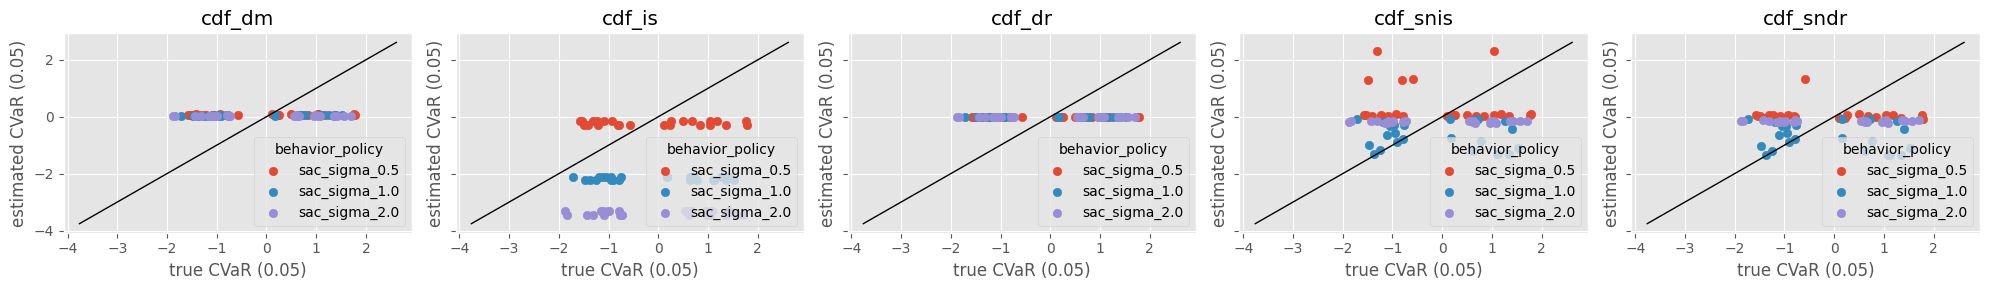

In [49]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the discrete action space, please refer to [examples/quickstart/basic_synthetic_discrete_multiple_datasets.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/basic_synthetic_discrete_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.